# Assignment 3

Imports

In [80]:
import numpy as np
import scipy as sp
from scipy.optimize import dual_annealing, curve_fit
from scipy.integrate import solve_ivp, odeint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
import math
import os
import random

In [81]:
SEED = 33
np.random.seed(SEED)

os.makedirs('media', exist_ok=True)

if not os.path.isfile('predator-prey-data.csv'):
    raise FileNotFoundError("File 'predator-prey-data.csv' not found.")

data = pd.read_csv('predator-prey-data.csv').drop(columns=['Unnamed: 0'])
t, x, y = data['t'].to_numpy(), data['x'].to_numpy(), data['y'].to_numpy()

In [82]:
LOW_PARAM_BOUND = 0
UP_PARAM_BOUND = 2
MAX_STEPS_HILLCLIMING = 500
MAX_ITER_SA = 100

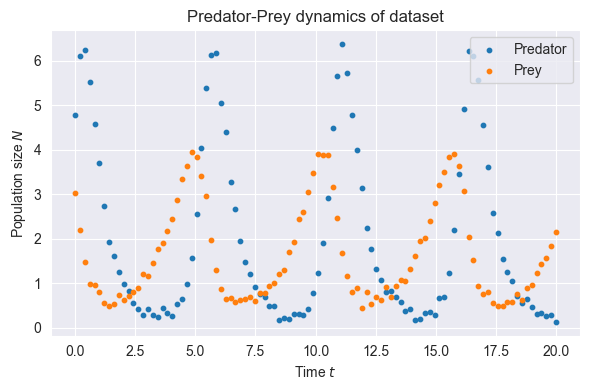

In [83]:
plt.figure(figsize=(6, 4), layout='tight')
plt.scatter(t, x, s=10, label='Predator')
plt.scatter(t, y, s=10, label='Prey')
plt.title('Predator-Prey dynamics of dataset')
plt.xlabel('Time $t$')
plt.ylabel('Population size $N$')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/dataset.png')
plt.show()

In [84]:
def solve_lv(params, init_conditions, t):
    alpha, beta, gamma, delta = params

    def lv_odes(y, t):
        x, z = y
        dxdt = alpha*x - beta*x*z
        dzdt = delta*x*z - gamma*z
        return np.array([dxdt, dzdt])

    solution = odeint(lv_odes, init_conditions, t)
    return solution

In [85]:
def get_initial_random_guess(lower_bound=LOW_PARAM_BOUND, upper_bound=UP_PARAM_BOUND):
    alpha = random.uniform(lower_bound, upper_bound)
    beta = random.uniform(lower_bound, upper_bound)
    gamma = random.uniform(lower_bound, upper_bound)
    delta = random.uniform(lower_bound, upper_bound)
    return [alpha, beta, gamma, delta]

In [86]:
def get_neighbors(solution, step_size=0.1):
    """Calculate the neighbors of a solution, given a step size."""
    neighbors = []
    for i in range(len(solution)):
        # Add step_size to the parameter if it doesn't exceed PARAM_MAX
        if solution[i] + step_size <= UP_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] + step_size for j in range(len(solution))])
        # Subtract step_size from the parameter if it doesn't become less than PARAM_MIN
        if solution[i] - step_size >= LOW_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] - step_size for j in range(len(solution))])
    return neighbors


def choose_next_step(loss_function, current_step):
    neighbors = get_neighbors(current_step)
    return min(neighbors, key=loss_function)


def hill_climbing(loss_function, initial_step, max_steps):
    """Perform the Hill Climbing optimization algorithm."""
    current_step = initial_step
    history = [current_step]

    for _ in range(max_steps):
        try:
            next_step = choose_next_step(loss_function, current_step)
            if loss_function(next_step) >= loss_function(current_step):
                break
            history.append(next_step)
            current_step = next_step
        except Exception as e:
            print(f"An error occurred during the hill climbing: {str(e)}")
            break

    return current_step, history

def classic_annealing(*args, **kwargs):
    return dual_annealing(*args, **kwargs, no_local_search=True)

In [87]:
def mse_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mse = mean_squared_error(data[['y', 'x']].values, sim_data)
    return mse

def mae_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mae = mean_absolute_error(data[['y', 'x']].values, np.abs(sim_data))
    return mae

In [88]:
bounds = [(LOW_PARAM_BOUND, UP_PARAM_BOUND)] * 4
initial_guess = get_initial_random_guess()
hc_optimizers = [hill_climbing]
sa_optimizers = [classic_annealing, dual_annealing]
optimizers = hc_optimizers + sa_optimizers
objectives = [mse_objective, mae_objective]
est_params = {opt.__name__: {obj.__name__: [] for obj in objectives} for opt in optimizers}


for obj in objectives:
    for opt in hc_optimizers:
        params, _ = hill_climbing(
            obj, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
        est_params[opt.__name__][obj.__name__] = params
        print(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")
    for opt in sa_optimizers:
        params = opt(obj, bounds=bounds, maxiter=MAX_ITER_SA).x
        est_params[opt.__name__][obj.__name__] = params
        print(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")

Params of hill_climbing with mse_objective: ['0.233', '0.292', '1.595', '1.102'] - Loss: 3.07e+00
Params of classic_annealing with mse_objective: ['1.359', '0.713', '1.511', '1.290'] - Loss: 2.64e-01


C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Params of dual_annealing with mse_objective: ['0.860', '0.440', '2.000', '1.158'] - Loss: 9.63e-03
Params of hill_climbing with mae_objective: ['0.233', '0.292', '1.595', '1.102'] - Loss: 1.15e+00
Params of classic_annealing with mae_objective: ['1.379', '0.586', '1.183', '0.682'] - Loss: 3.44e-01


C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (

Params of dual_annealing with mae_objective: ['0.876', '0.448', '1.965', '1.142'] - Loss: 7.79e-02


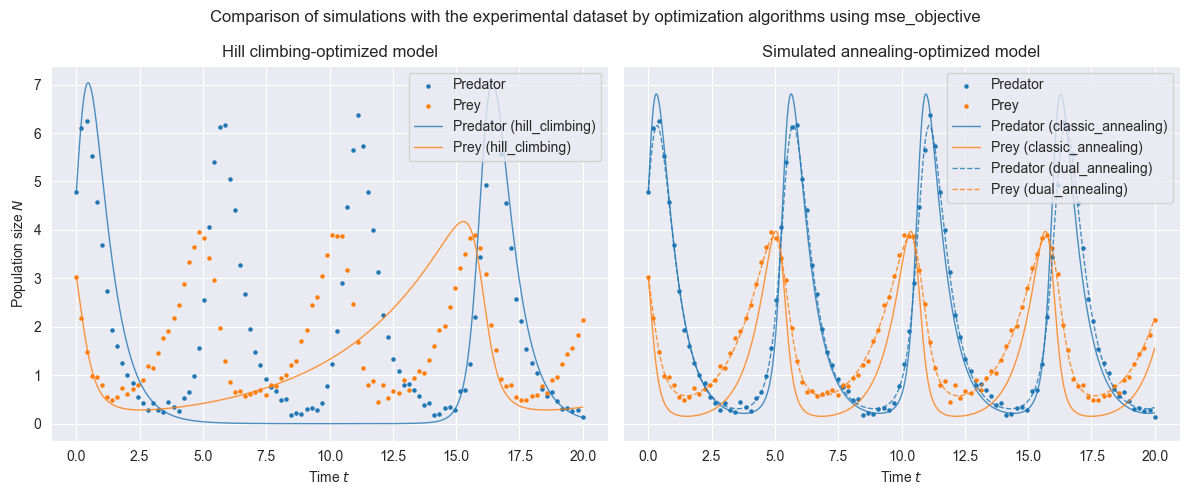

In [89]:
def plot_comparison_optimizers(hc_optimizers, sa_optimizers, objective=mse_objective, linestyles=['-', '--', ':'], colors=['tab:blue', 'tab:orange']):
    t_detail = np.linspace(0, 20, 1000)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='tight', sharey=True)
    fig.suptitle(f'Comparison of simulations with the experimental dataset by optimization algorithms using {objective.__name__}')
    axs[0].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[0].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(hc_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[0].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[0].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[0].set_title('Hill climbing-optimized model')
    axs[0].set_xlabel('Time $t$')
    axs[0].set_ylabel('Population size $N$')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    axs[1].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[1].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(sa_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[1].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[1].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[1].set_title('Simulated annealing-optimized model')
    axs[1].set_xlabel('Time $t$')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)
    plt.savefig('media/comparison_optimizers.png')
    plt.show()

plot_comparison_optimizers(hc_optimizers, sa_optimizers)

Removing samples functionality

  0%|          | 1/200 [00:01<06:33,  1.98s/it]

params: [1.52896196 0.78131841 1.25314822 0.93832918]
Minimum and Maximum of sim_data: 0.18398845488847185, 4.968753733844981
MSE: 1.0445680871641256


  1%|          | 2/200 [00:03<06:25,  1.95s/it]

params: [1.6781722  0.74935209 1.29059731 1.38240414]
Minimum and Maximum of sim_data: 0.08395607076440997, 7.148716636939738
MSE: 3.727136985238018


  2%|▏         | 3/200 [00:05<06:21,  1.94s/it]

params: [1.39097102 0.87323402 1.6695456  1.57310583]
Minimum and Maximum of sim_data: 0.09062586849375898, 4.78163509155479
MSE: 6.416601120477347


  2%|▏         | 4/200 [00:07<06:11,  1.89s/it]

params: [1.25202838 0.53490431 1.29117065 0.75041856]
Minimum and Maximum of sim_data: 0.5346955767181971, 5.4890156129682515
MSE: 5.2295067027958035


  2%|▎         | 5/200 [00:09<06:02,  1.86s/it]

params: [0.94646042 0.60646097 1.88208536 0.99111861]
Minimum and Maximum of sim_data: 0.2068165352792555, 5.3618137844465785
MSE: 4.120939364106352


  3%|▎         | 6/200 [00:11<05:53,  1.82s/it]

params: [1.1371401  0.62625959 1.56498494 0.92377279]
Minimum and Maximum of sim_data: 0.30494414173955103, 4.78163509155479
MSE: 6.789374034560707


  4%|▎         | 7/200 [00:12<05:46,  1.79s/it]

params: [0.83084308 0.40021513 1.9674627  1.05598037]
Minimum and Maximum of sim_data: 0.42921820284989454, 5.6714629076090155
MSE: 1.6766080871215763


  4%|▍         | 8/200 [00:14<05:44,  1.79s/it]

params: [1.26029745 0.78369499 1.48835422 0.87359194]
Minimum and Maximum of sim_data: 0.28614545271681624, 5.197192361503392
MSE: 5.588453537968748


  4%|▍         | 9/200 [00:16<05:51,  1.84s/it]

params: [1.83286931 1.4467351  1.53087232 1.5200254 ]
Minimum and Maximum of sim_data: 0.030790580952152424, 4.78163509155479
MSE: 1.9633902383892186


  5%|▌         | 10/200 [00:18<05:51,  1.85s/it]

params: [1.90246697 1.07539493 1.20994773 1.20901014]
Minimum and Maximum of sim_data: 0.05174437397445761, 4.78163509155479
MSE: 0.4621869048944233


  6%|▌         | 11/200 [00:20<05:50,  1.86s/it]

params: [1.27592649 0.60769612 1.59849182 1.44772208]
Minimum and Maximum of sim_data: 0.15569741562392816, 6.770215019103283
MSE: 8.029649940095325


  6%|▌         | 12/200 [00:22<05:45,  1.84s/it]

params: [1.5811698  0.72296625 1.13764509 0.81314313]
Minimum and Maximum of sim_data: 0.2347257010021524, 5.7890364818967015
MSE: 9.815117830938796


  6%|▋         | 13/200 [00:24<05:45,  1.85s/it]

params: [1.2893613  0.65182675 1.42192879 1.00327751]
Minimum and Maximum of sim_data: 0.26922006881606697, 5.877961125696138
MSE: 0.07033718993961598


  7%|▋         | 14/200 [00:25<05:41,  1.84s/it]

params: [1.56672864 0.82527936 1.16477473 0.74166288]
Minimum and Maximum of sim_data: 0.22869678617646763, 5.198668358449429
MSE: 4.907518255743991


  8%|▊         | 15/200 [00:27<05:36,  1.82s/it]

params: [1.00603941 0.4893897  1.74871156 1.12709859]
Minimum and Maximum of sim_data: 0.36112203261669484, 4.78163509155479
MSE: 5.573619577982427


  8%|▊         | 16/200 [00:29<05:30,  1.80s/it]

params: [1.61873187 1.01528707 1.37533386 1.19232178]
Minimum and Maximum of sim_data: 0.08255229925794054, 4.78163509155479
MSE: 9.68922291463225


  8%|▊         | 17/200 [00:31<05:27,  1.79s/it]

params: [1.17736772 0.52809253 1.35552647 0.73967398]
Minimum and Maximum of sim_data: 0.5922434577909856, 5.216114931778617
MSE: 3.268585029784365


  9%|▉         | 18/200 [00:33<05:33,  1.83s/it]

params: [1.91990302 0.94063689 1.11183973 1.12837632]
Minimum and Maximum of sim_data: 0.0654253071185572, 6.549859152853339
MSE: 6.768127794377414


 10%|▉         | 19/200 [00:34<05:30,  1.83s/it]

params: [1.8329334  1.07555542 1.08365076 0.69358779]
Minimum and Maximum of sim_data: 0.12797620189788558, 5.888368067273237
MSE: 0.6075214341803379


 10%|█         | 20/200 [00:36<05:31,  1.84s/it]

params: [1.25806814 0.81968714 1.48443153 0.7722389 ]
Minimum and Maximum of sim_data: 0.24740343331206793, 5.429665895826636
MSE: 8.787967001626933


 10%|█         | 21/200 [00:38<05:26,  1.82s/it]

params: [1.47788326 0.65902416 1.16076546 0.75899926]
Minimum and Maximum of sim_data: 0.32304503695461184, 5.671272055772568
MSE: 7.020749319579445


 11%|█         | 22/200 [00:40<05:21,  1.81s/it]

params: [1.8839591  0.9531992  1.02988722 0.7310216 ]
Minimum and Maximum of sim_data: 0.14683416853525746, 5.13879219515781
MSE: 0.24232990497609405


 12%|█▏        | 23/200 [00:42<05:23,  1.83s/it]

params: [1.26416543 0.64269969 1.50233737 1.16668994]
Minimum and Maximum of sim_data: 0.21796655790572342, 6.518055940807836
MSE: 5.63289329354358


 12%|█▏        | 24/200 [00:44<05:22,  1.83s/it]

params: [1.17585784 0.6863369  1.51840749 0.85884675]
Minimum and Maximum of sim_data: 0.27633701797785365, 5.368741227224382
MSE: 0.1601423204878235


 12%|█▎        | 25/200 [00:45<05:20,  1.83s/it]

params: [1.57845702 0.71410906 1.13755965 0.81717977]
Minimum and Maximum of sim_data: 0.23619366714462073, 5.804499453588496
MSE: 0.41441454083682727


 13%|█▎        | 26/200 [00:47<05:13,  1.80s/it]

params: [1.60167665 1.0087172  1.4797083  1.4287327 ]
Minimum and Maximum of sim_data: 0.06455593682665359, 4.961340247635395
MSE: 6.264250118090313


 14%|█▎        | 27/200 [00:49<05:20,  1.85s/it]

params: [1.95002076 0.94792327 1.02787642 0.7878996 ]
Minimum and Maximum of sim_data: 0.1316257571742025, 5.508491714230782
MSE: 0.5678838782847087


 14%|█▍        | 28/200 [00:51<05:20,  1.86s/it]

params: [1.90503868 0.89091577 0.99032063 0.78147905]
Minimum and Maximum of sim_data: 0.13618880069211872, 5.66857904570823
MSE: 0.7285917913783717


 14%|█▍        | 29/200 [00:53<05:21,  1.88s/it]

params: [1.4791126  0.92159196 1.51285095 1.34002608]
Minimum and Maximum of sim_data: 0.09808542073184535, 6.144505836525589
MSE: 4.098508188171469


 15%|█▌        | 30/200 [00:55<05:13,  1.84s/it]

params: [1.82697593 0.78500507 0.98709134 0.7519181 ]
Minimum and Maximum of sim_data: 0.19264837219575584, 5.122931457440596
MSE: 0.25885123181775055


 16%|█▌        | 31/200 [00:57<05:19,  1.89s/it]

params: [1.96562946 1.39556435 1.39977071 1.51340258]
Minimum and Maximum of sim_data: 0.022531117933270166, 5.472718761626395
MSE: 0.7015121900257328


 16%|█▌        | 32/200 [00:59<05:34,  1.99s/it]

params: [1.1162376  0.51314592 1.59738931 1.17304765]
Minimum and Maximum of sim_data: 0.30931429418026696, 6.912006270694463
MSE: 4.816330115339387


 16%|█▋        | 33/200 [01:01<05:40,  2.04s/it]

params: [0.91948211 0.5770139  1.87201284 0.91345366]
Minimum and Maximum of sim_data: 0.2300399572389033, 5.201766175204397
MSE: 0.7812978135383086


 17%|█▋        | 34/200 [01:03<05:43,  2.07s/it]

params: [0.9441019  0.48959105 1.69230967 0.81058713]
Minimum and Maximum of sim_data: 0.4352367954106647, 5.229538252559758
MSE: 0.5348678255007795


 18%|█▊        | 35/200 [01:05<05:35,  2.03s/it]

params: [1.56831076 1.25083282 1.79870271 1.86897546]
Minimum and Maximum of sim_data: 0.03445889261193078, 6.6348509237684405
MSE: 1.1454760456612574


 18%|█▊        | 36/200 [01:07<05:29,  2.01s/it]

params: [1.05864225 0.58427474 1.8544902  1.36058574]
Minimum and Maximum of sim_data: 0.17876079809154366, 6.613078416882992
MSE: 0.364713242243843


 18%|█▊        | 37/200 [01:09<05:21,  1.97s/it]

params: [1.35159837 0.89593902 1.53635223 1.09188069]
Minimum and Maximum of sim_data: 0.14454933594595037, 5.640079486767951
MSE: 9.788627556727898


 19%|█▉        | 38/200 [01:11<05:15,  1.95s/it]

params: [1.29666275 0.83287294 1.54100504 1.04458877]
Minimum and Maximum of sim_data: 0.1658008840477424, 5.393641048364612
MSE: 1.545064865527456


 20%|█▉        | 39/200 [01:13<05:04,  1.89s/it]

params: [1.57008089 0.75551582 1.15001411 0.80308739]
Minimum and Maximum of sim_data: 0.2252914558868249, 5.202893601761451
MSE: 1.821523310990838


 20%|██        | 40/200 [01:14<04:57,  1.86s/it]

params: [1.07206174 0.46003326 1.56257874 0.98363072]
Minimum and Maximum of sim_data: 0.4892843765515274, 5.701535061534435
MSE: 0.1262659496724418


 20%|██        | 41/200 [01:16<04:57,  1.87s/it]

params: [1.55207984 0.74004519 1.2297619  0.98601179]
Minimum and Maximum of sim_data: 0.17191780119079153, 6.238333729465427
MSE: 0.42464421604749886


 21%|██        | 42/200 [01:18<04:48,  1.83s/it]

params: [1.17982512 0.60458257 1.39855899 0.7328087 ]
Minimum and Maximum of sim_data: 0.4512792954045449, 5.247179046857138
MSE: 1.0634013774682278


 22%|██▏       | 43/200 [01:20<04:52,  1.86s/it]

params: [1.87587389 1.1115016  1.23439207 1.17651524]
Minimum and Maximum of sim_data: 0.05313303831911283, 5.7153025089139655
MSE: 7.264478062404169


 22%|██▏       | 44/200 [01:22<04:47,  1.84s/it]

params: [1.03007974 0.49050685 1.67902652 1.08283155]
Minimum and Maximum of sim_data: 0.36662331542751453, 6.339182281663544
MSE: 0.05838173616203321


 22%|██▎       | 45/200 [01:24<04:42,  1.82s/it]

params: [1.05310775 0.48650402 1.57285689 0.88475144]
Minimum and Maximum of sim_data: 0.5186828256567724, 5.593470846023502
MSE: 4.048940239753653


 23%|██▎       | 46/200 [01:25<04:35,  1.79s/it]

params: [1.87826328 0.82607486 0.99814318 0.83247831]
Minimum and Maximum of sim_data: 0.14191226603557328, 6.000955738369231
MSE: 0.3376925564221779


 24%|██▎       | 47/200 [01:27<04:39,  1.83s/it]

params: [1.28982152 0.99147286 1.92024522 1.66057795]
Minimum and Maximum of sim_data: 0.047066647008534045, 6.00890199804203
MSE: 0.5980574642255223


 24%|██▍       | 48/200 [01:29<04:38,  1.83s/it]

params: [1.13875395 0.64100959 1.7719076  1.38161814]
Minimum and Maximum of sim_data: 0.1617222075124585, 6.46874164341957
MSE: 3.5487467133420787


 24%|██▍       | 49/200 [01:31<04:38,  1.84s/it]

params: [1.44256216 0.90300526 1.56296925 1.4047841 ]
Minimum and Maximum of sim_data: 0.09460171921869923, 6.53115429453108
MSE: 0.36242878637998255


 25%|██▌       | 50/200 [01:33<04:36,  1.85s/it]

params: [1.1928154  0.82170122 1.79749778 1.33291252]
Minimum and Maximum of sim_data: 0.09808601658154811, 6.077424938742716
MSE: 0.49930797638110314


 26%|██▌       | 51/200 [01:35<04:35,  1.85s/it]

params: [1.37961746 0.82970441 1.38973321 0.86788886]
Minimum and Maximum of sim_data: 0.23405714068643904, 5.381147420508834
MSE: 0.7546304856811219


 26%|██▌       | 52/200 [01:36<04:32,  1.84s/it]

params: [1.26328212 0.87692917 1.75572125 1.37610344]
Minimum and Maximum of sim_data: 0.09228121931201924, 6.155895385200059
MSE: 5.1145117379167875


 26%|██▋       | 53/200 [01:38<04:27,  1.82s/it]

params: [1.99228631 0.83150849 0.85554817 0.5486725 ]
Minimum and Maximum of sim_data: 0.2520250283369047, 5.3259215183133035
MSE: 3.8049479170941614


 27%|██▋       | 54/200 [01:40<04:28,  1.84s/it]

params: [1.95434359 1.16916551 1.0991903  0.81527378]
Minimum and Maximum of sim_data: 0.08183524088594667, 5.616567384944873
MSE: 1.0536826881767196


 28%|██▊       | 55/200 [01:42<04:24,  1.82s/it]

params: [1.19675555 0.68259053 1.51610776 0.92808584]
Minimum and Maximum of sim_data: 0.2696265210990848, 5.551196025907435
MSE: 0.12343626518975734


 28%|██▊       | 56/200 [01:44<04:26,  1.85s/it]

params: [1.46457997 1.15925336 1.84305934 1.78019444]
Minimum and Maximum of sim_data: 0.03835127231475944, 6.537321606810588
MSE: 0.8299405519404452


 28%|██▊       | 57/200 [01:46<04:24,  1.85s/it]

params: [1.15135895 0.57517311 1.69489367 1.32048021]
Minimum and Maximum of sim_data: 0.2389448429668883, 6.831238743583611
MSE: 0.32553316712120717


 29%|██▉       | 58/200 [01:47<04:21,  1.84s/it]

params: [1.63770504 0.84441161 1.09572513 0.65689186]
Minimum and Maximum of sim_data: 0.24730711305956776, 5.245295747364652
MSE: 0.24870101876477851


 30%|██▉       | 59/200 [01:49<04:26,  1.89s/it]

params: [1.9308051  1.17334292 1.42853665 1.84773736]
Minimum and Maximum of sim_data: 0.02016501311960415, 7.298889327439133
MSE: 3.229011488112498


 30%|███       | 60/200 [01:51<04:22,  1.87s/it]

params: [1.07006513 0.68062889 1.80766997 1.19079516]
Minimum and Maximum of sim_data: 0.14978180969186056, 5.359776030022957
MSE: 0.6586471689927118


 30%|███       | 61/200 [01:53<04:16,  1.84s/it]

params: [0.80152042 0.3572686  1.97532421 1.03004932]
Minimum and Maximum of sim_data: 0.5306446471311443, 5.956568861573655
MSE: 1.9378606635066782


 31%|███       | 62/200 [01:55<04:15,  1.85s/it]

params: [1.671435   0.67683461 1.131167   1.0135376 ]
Minimum and Maximum of sim_data: 0.15270016873460962, 6.882855831375055
MSE: 8.839378422930114


 32%|███▏      | 63/200 [01:57<04:07,  1.81s/it]

params: [1.01265966 0.50441839 1.59376198 0.80448785]
Minimum and Maximum of sim_data: 0.4739035746033479, 5.329483713652975
MSE: 0.08597029298815656


 32%|███▏      | 64/200 [01:58<04:07,  1.82s/it]

params: [1.76700899 0.95457315 1.14190928 0.89580595]
Minimum and Maximum of sim_data: 0.1151234561087642, 5.5102646656590295
MSE: 0.5240820417510078


 32%|███▎      | 65/200 [02:00<04:05,  1.82s/it]

params: [0.85896957 0.41675356 1.93772576 1.06862297]
Minimum and Maximum of sim_data: 0.3985681239400809, 5.956204302369513
MSE: 0.8308357822512653


 33%|███▎      | 66/200 [02:02<04:05,  1.83s/it]

params: [1.45627959 0.60140597 1.32823349 1.19574667]
Minimum and Maximum of sim_data: 0.16636076747820316, 7.30319255819403
MSE: 2.261548675588787


 34%|███▎      | 67/200 [02:04<04:03,  1.83s/it]

params: [1.82499158 0.9022944  1.23683855 1.36030184]
Minimum and Maximum of sim_data: 0.05697475036231492, 7.144473173388377
MSE: 2.9892292684392023


 34%|███▍      | 68/200 [02:06<04:04,  1.85s/it]

params: [1.72488423 1.15756181 1.4383873  1.40660425]
Minimum and Maximum of sim_data: 0.0469109699841836, 6.275129139579534
MSE: 2.5588178427572688


 34%|███▍      | 69/200 [02:08<03:57,  1.81s/it]

params: [1.70131248 0.67275828 0.93851689 0.52927092]
Minimum and Maximum of sim_data: 0.4462223480249954, 5.268203822314675
MSE: 0.3500380686832228


 35%|███▌      | 70/200 [02:09<03:56,  1.82s/it]

params: [1.34869481 0.67477393 1.50831148 1.30313128]
Minimum and Maximum of sim_data: 0.158862338187278, 7.020359093328774
MSE: 1.2146805283534843


 36%|███▌      | 71/200 [02:11<03:52,  1.80s/it]

params: [0.98201788 0.46536623 1.609115   0.81012517]
Minimum and Maximum of sim_data: 0.5402776673468113, 5.372138774276357
MSE: 0.3365614885745827


 36%|███▌      | 72/200 [02:13<04:07,  1.93s/it]

params: [1.0016701  0.43214242 1.54017979 0.80999365]
Minimum and Maximum of sim_data: 0.6665322311753702, 5.535060108781137
MSE: 0.18772116430251445


 36%|███▋      | 73/200 [02:16<04:22,  2.06s/it]

params: [0.96524391 0.45302518 1.80973544 1.12019907]
Minimum and Maximum of sim_data: 0.3819154470756881, 6.372087156507505
MSE: 3.8673922348425993


 37%|███▋      | 74/200 [02:18<04:29,  2.14s/it]

params: [1.45068526 1.13352417 1.68304901 1.36335799]
Minimum and Maximum of sim_data: 0.06263950681501781, 5.779835003032513
MSE: 3.441038819033058


 38%|███▊      | 75/200 [02:20<04:31,  2.17s/it]

params: [1.67665614 1.11112761 1.54424942 1.65263452]
Minimum and Maximum of sim_data: 0.04139613771825711, 6.782207351576361
MSE: 0.7952132258275676


 38%|███▊      | 76/200 [02:22<04:24,  2.13s/it]

params: [1.27576977 0.74630189 1.49403709 0.98504261]
Minimum and Maximum of sim_data: 0.23328130466277766, 5.562701824264868
MSE: 2.7808112947874264


 38%|███▊      | 77/200 [02:25<04:30,  2.20s/it]

params: [1.38856717 0.86497627 1.72922498 1.73685927]
Minimum and Maximum of sim_data: 0.0763292534317567, 7.330338679775312
MSE: 0.5619963424547454


 39%|███▉      | 78/200 [02:27<04:26,  2.18s/it]

params: [1.14224967 0.4778114  1.4857334  1.0002302 ]
Minimum and Maximum of sim_data: 0.4096794610833725, 6.553111747879814
MSE: 0.20519733411341934


 40%|███▉      | 79/200 [02:29<04:26,  2.20s/it]

params: [1.87682944 1.01913793 1.05129581 0.70089178]
Minimum and Maximum of sim_data: 0.1403665382384911, 5.479802576834717
MSE: 4.148536792900664


 40%|████      | 80/200 [02:31<04:13,  2.11s/it]

params: [1.22493051 0.64822432 1.46826428 0.93462536]
Minimum and Maximum of sim_data: 0.3285052327061253, 5.255883820275025
MSE: 0.8838905423041725


 40%|████      | 81/200 [02:33<04:01,  2.03s/it]

params: [1.50037308 0.76010063 1.36236741 1.16676772]
Minimum and Maximum of sim_data: 0.14078675268963514, 6.450249981958155
MSE: 0.3133676614832421


 41%|████      | 82/200 [02:35<03:57,  2.01s/it]

params: [1.37558638 0.56489672 1.33884582 1.13312883]
Minimum and Maximum of sim_data: 0.20643036324099037, 7.286106718071065
MSE: 0.4353797198713253


 42%|████▏     | 83/200 [02:37<03:52,  1.99s/it]

params: [1.78249703 0.98587362 1.08741491 0.72598175]
Minimum and Maximum of sim_data: 0.14664370588947032, 5.574674180224368
MSE: 0.5580975114522964


 42%|████▏     | 84/200 [02:39<03:48,  1.97s/it]

params: [1.03987163 0.59846938 1.86269574 1.31692287]
Minimum and Maximum of sim_data: 0.16982342118168392, 6.490575937484459
MSE: 0.4346097234309833


 42%|████▎     | 85/200 [02:41<03:45,  1.96s/it]

params: [1.30346978 0.79688725 1.5965964  1.25549948]
Minimum and Maximum of sim_data: 0.15166597515207564, 6.254075154518243
MSE: 0.24779604137557287


 43%|████▎     | 86/200 [02:42<03:38,  1.92s/it]

params: [1.41719552 0.78100918 1.38385303 1.03768895]
Minimum and Maximum of sim_data: 0.18042257540421816, 5.995637376050801
MSE: 0.3876046231740529


 44%|████▎     | 87/200 [02:44<03:38,  1.94s/it]

params: [1.119667   0.81016845 1.96538746 1.49506635]
Minimum and Maximum of sim_data: 0.0693462311053664, 6.299304668258482
MSE: 0.9263139258808674


 44%|████▍     | 88/200 [02:47<03:40,  1.97s/it]

params: [1.54313005 0.88592934 1.48708333 1.49334631]
Minimum and Maximum of sim_data: 0.07220218931169943, 7.011190034893923
MSE: 0.42799001048418533


 44%|████▍     | 89/200 [02:49<03:40,  1.98s/it]

params: [1.87033349 0.90824066 1.3577486  1.80342431]
Minimum and Maximum of sim_data: 0.028916535034369452, 8.361305465304897
MSE: 1.1646047761105598


 45%|████▌     | 90/200 [02:50<03:35,  1.96s/it]

params: [1.72004956 0.97700323 1.33257443 1.33855855]
Minimum and Maximum of sim_data: 0.06064219891521894, 6.325449391244962
MSE: 1.539041807778196


 46%|████▌     | 91/200 [02:52<03:28,  1.91s/it]

params: [1.34052521 0.80343395 1.40562657 0.86893228]
Minimum and Maximum of sim_data: 0.24390589633203666, 5.414797807601655
MSE: 0.21350596504293787


 46%|████▌     | 92/200 [02:54<03:22,  1.87s/it]

params: [1.24020133 0.80046719 1.57027429 0.95208214]
Minimum and Maximum of sim_data: 0.1837117953104284, 5.430388527579365
MSE: 0.25164701288630376


 46%|████▋     | 93/200 [02:56<03:19,  1.86s/it]

params: [0.90635154 0.35540247 1.66891091 0.78830656]
Minimum and Maximum of sim_data: 0.9181248312449695, 5.468665829565191
MSE: 0.8525086946997112


 47%|████▋     | 94/200 [02:58<03:16,  1.85s/it]

params: [1.26803356 0.60889125 1.40349501 0.95381126]
Minimum and Maximum of sim_data: 0.31391700083932733, 6.014649117921051
MSE: 0.07709011237136489


 48%|████▊     | 95/200 [02:59<03:13,  1.84s/it]

params: [0.99180051 0.413597   1.47738439 0.66989994]
Minimum and Maximum of sim_data: 0.8558867234645431, 5.13874960446821
MSE: 0.653453728198256


 48%|████▊     | 96/200 [03:01<03:06,  1.80s/it]

params: [0.99241149 0.46958846 1.6147402  0.82640943]
Minimum and Maximum of sim_data: 0.5329185098602255, 5.440219662593997
MSE: 0.09527119616696338


 48%|████▊     | 97/200 [03:03<03:07,  1.82s/it]

params: [1.29529584 0.81368824 1.6761281  1.39068   ]
Minimum and Maximum of sim_data: 0.11833428820899956, 6.490139399320216
MSE: 0.3057249901215868


 49%|████▉     | 98/200 [03:05<03:03,  1.80s/it]

params: [0.81475198 0.4100716  1.99469864 1.03716133]
Minimum and Maximum of sim_data: 0.3888906735166527, 5.683613910712319
MSE: 1.5227268320528429


 50%|████▉     | 99/200 [03:07<03:02,  1.81s/it]

params: [1.66298257 0.78040254 1.07262371 0.71627494]
Minimum and Maximum of sim_data: 0.2432457043863621, 5.532883812061954
MSE: 0.3786417908823984


 50%|█████     | 100/200 [03:09<03:02,  1.83s/it]

params: [1.47609126 0.82348392 1.44442095 1.34586361]
Minimum and Maximum of sim_data: 0.09821610007551344, 6.773896151919507
MSE: 0.9277816056396102


 50%|█████     | 101/200 [03:10<03:02,  1.84s/it]

params: [1.46379087 0.88426446 1.2687721  0.66733789]
Minimum and Maximum of sim_data: 0.27321693068318104, 6.209590862203565
MSE: 0.4901816028174057


 51%|█████     | 102/200 [03:12<02:59,  1.84s/it]

params: [1.99398193 1.06237794 1.02886495 0.79525999]
Minimum and Maximum of sim_data: 0.095474396966859, 5.520901115332281
MSE: 0.5659288510131819


 52%|█████▏    | 103/200 [03:14<02:55,  1.80s/it]

params: [1.1468849  0.48906163 1.50286773 1.02262939]
Minimum and Maximum of sim_data: 0.39146343684699497, 6.572183642143231
MSE: 0.15771048273775912


 52%|█████▏    | 104/200 [03:16<02:51,  1.79s/it]

params: [1.86779568 0.77627316 0.9120294  0.57695594]
Minimum and Maximum of sim_data: 0.28867976062389494, 5.379779117299352
MSE: 0.29170358058199


 52%|█████▎    | 105/200 [03:18<02:53,  1.82s/it]

params: [1.87415083 1.00459701 1.03927103 0.65120129]
Minimum and Maximum of sim_data: 0.1635714202843156, 5.854491626829438
MSE: 0.4666479637664679


 53%|█████▎    | 106/200 [03:19<02:51,  1.82s/it]

params: [1.35088326 0.82560853 1.63637765 1.44394586]
Minimum and Maximum of sim_data: 0.11441675592017117, 6.706078543017718
MSE: 1.4539791641322322


 54%|█████▎    | 107/200 [03:21<02:49,  1.82s/it]

params: [1.2570674  0.58161603 1.52212765 1.21800002]
Minimum and Maximum of sim_data: 0.22722435084861314, 7.020696811126264
MSE: 0.2336907254504365


 54%|█████▍    | 108/200 [03:23<02:50,  1.86s/it]

params: [1.29505685 0.72151485 1.42522355 0.92576316]
Minimum and Maximum of sim_data: 0.2707694650695791, 5.6637293520844265
MSE: 1.7303660711809599


 55%|█████▍    | 109/200 [03:25<02:51,  1.88s/it]

params: [1.7658218  0.87406453 1.04870129 0.70314751]
Minimum and Maximum of sim_data: 0.19275847691027329, 5.413793328002708
MSE: 0.21589596318836307


 55%|█████▌    | 110/200 [03:27<02:47,  1.86s/it]

params: [1.34427214 0.86598934 1.43402673 0.86762802]
Minimum and Maximum of sim_data: 0.19660826411944726, 5.439225446975904
MSE: 2.6290508738573592


 56%|█████▌    | 111/200 [03:29<02:44,  1.85s/it]

params: [0.98409094 0.49639607 1.74310221 1.03507033]
Minimum and Maximum of sim_data: 0.3506146469548826, 5.967575424638163
MSE: 0.019858986934413493


 56%|█████▌    | 112/200 [03:31<02:40,  1.82s/it]

params: [1.00236573 0.45657771 1.57842508 0.83658908]
Minimum and Maximum of sim_data: 0.5689561177541749, 5.578804556907223
MSE: 0.11271267722044641


 56%|█████▋    | 113/200 [03:32<02:40,  1.84s/it]

params: [1.3610792  0.828706   1.65927938 1.5196988 ]
Minimum and Maximum of sim_data: 0.10377040540450583, 6.887429159230312
MSE: 0.40842086284418


 57%|█████▋    | 114/200 [03:34<02:38,  1.84s/it]

params: [1.87286615 1.10746313 1.14699041 0.89939908]
Minimum and Maximum of sim_data: 0.08283976178891032, 5.515521543606456
MSE: 0.6980038971366485


 57%|█████▊    | 115/200 [03:36<02:33,  1.81s/it]

params: [1.41522808 0.68570087 1.21816278 0.74720211]
Minimum and Maximum of sim_data: 0.3324993184554812, 5.410534622932435
MSE: 0.993067666644166


 58%|█████▊    | 116/200 [03:38<02:30,  1.79s/it]

params: [1.02767712 0.57170568 1.71736249 1.01252148]
Minimum and Maximum of sim_data: 0.27564713098477184, 5.717170796268966
MSE: 0.04584176663875412


 58%|█████▊    | 117/200 [03:39<02:27,  1.78s/it]

params: [1.09632504 0.58235608 1.64528372 1.06300407]
Minimum and Maximum of sim_data: 0.2849755474119852, 6.001568129875444
MSE: 1.840762928799049


 59%|█████▉    | 118/200 [03:41<02:29,  1.83s/it]

params: [1.33222295 1.05725398 1.87373493 1.58359124]
Minimum and Maximum of sim_data: 0.046445980219116154, 6.212622327979886
MSE: 0.6592990178123634


 60%|█████▉    | 119/200 [03:43<02:25,  1.80s/it]

params: [0.92608481 0.46215223 1.83733901 1.02372865]
Minimum and Maximum of sim_data: 0.38367897486425534, 5.838570318969905
MSE: 0.6003419760390519


 60%|██████    | 120/200 [03:45<02:28,  1.85s/it]

params: [1.31590423 0.95019954 1.8428374  1.62889337]
Minimum and Maximum of sim_data: 0.059632008146525146, 6.553615327231465
MSE: 0.5901552053266397


 60%|██████    | 121/200 [03:47<02:25,  1.84s/it]

params: [1.1325468  0.82727808 1.86902986 1.2216063 ]
Minimum and Maximum of sim_data: 0.0954897837091646, 5.696113056735326
MSE: 0.4297969759576796


 61%|██████    | 122/200 [03:49<02:25,  1.86s/it]

params: [1.8785893  1.28855114 1.45920774 1.65833632]
Minimum and Maximum of sim_data: 0.02430872364692561, 6.627448339109133
MSE: 0.9014311951929975


 62%|██████▏   | 123/200 [03:51<02:23,  1.86s/it]

params: [1.17011441 0.60720369 1.73054008 1.41312953]
Minimum and Maximum of sim_data: 0.1898227195651687, 7.195640336345809
MSE: 1.091991042569261


 62%|██████▏   | 124/200 [03:52<02:19,  1.84s/it]

params: [1.01439724 0.47841799 1.6163309  0.89912814]
Minimum and Maximum of sim_data: 0.4854024919188129, 5.716243541671041
MSE: 0.2600111721573325


 62%|██████▎   | 125/200 [03:54<02:16,  1.82s/it]

params: [1.03044217 0.65922404 1.94591041 1.3225434 ]
Minimum and Maximum of sim_data: 0.12850198678339278, 6.183255655055356
MSE: 0.25460297714626184


 63%|██████▎   | 126/200 [03:56<02:16,  1.84s/it]

params: [1.35282435 0.97642114 1.7529429  1.49258747]
Minimum and Maximum of sim_data: 0.0702039651266144, 6.301611917849547
MSE: 1.2231944180758179


 64%|██████▎   | 127/200 [03:58<02:15,  1.85s/it]

params: [1.63324406 0.8733671  1.39561444 1.47168568]
Minimum and Maximum of sim_data: 0.06457614571736761, 7.206274253729509
MSE: 0.43600539660195203


 64%|██████▍   | 128/200 [04:00<02:11,  1.83s/it]

params: [1.09045244 0.58714737 1.60147436 0.93664612]
Minimum and Maximum of sim_data: 0.32255737605224116, 5.634652686739243
MSE: 0.06324985501353127


 64%|██████▍   | 129/200 [04:02<02:09,  1.83s/it]

params: [1.24863733 0.62742112 1.5650159  1.27893517]
Minimum and Maximum of sim_data: 0.1962404443220809, 6.931081932631666
MSE: 0.6143605147013071


 65%|██████▌   | 130/200 [04:03<02:06,  1.80s/it]

params: [0.9868761  0.52444631 1.72492288 0.95295328]
Minimum and Maximum of sim_data: 0.34167181588923157, 5.60372389765524
MSE: 0.043900725016278425


 66%|██████▌   | 131/200 [04:05<02:06,  1.84s/it]

params: [1.90131059 0.93753506 0.92744107 0.49432429]
Minimum and Maximum of sim_data: 0.2463861005620042, 6.34073275761644
MSE: 0.46089591662551915


 66%|██████▌   | 132/200 [04:07<02:05,  1.85s/it]

params: [1.51521867 0.94069207 1.50962819 1.42897153]
Minimum and Maximum of sim_data: 0.07620511871675245, 6.616699164227522
MSE: 0.4614053199127744


 66%|██████▋   | 133/200 [04:09<02:03,  1.85s/it]

params: [1.06155959 0.65045792 1.91584772 1.40526744]
Minimum and Maximum of sim_data: 0.1280403467913446, 6.549860145066802
MSE: 0.19091286091416076


 67%|██████▋   | 134/200 [04:11<02:01,  1.85s/it]

params: [1.62493425 1.07324824 1.37629265 1.10821278]
Minimum and Maximum of sim_data: 0.08607322601620741, 5.770916578277561
MSE: 0.4975668842135222


 68%|██████▊   | 135/200 [04:13<01:59,  1.84s/it]

params: [1.30437047 0.59469104 1.28869678 0.80599054]
Minimum and Maximum of sim_data: 0.38586842800575033, 5.716717309585989
MSE: 0.10920746217709179


 68%|██████▊   | 136/200 [04:15<01:57,  1.84s/it]

params: [1.17221584 0.79715478 1.6158432  0.86066739]
Minimum and Maximum of sim_data: 0.17251541970113796, 5.625936834415379
MSE: 0.37507577165249756


 68%|██████▊   | 137/200 [04:16<01:53,  1.80s/it]

params: [1.49908108 0.59969335 1.07177395 0.62541211]
Minimum and Maximum of sim_data: 0.469266508478481, 5.47397372555356
MSE: 0.29243290271609934


 69%|██████▉   | 138/200 [04:18<01:50,  1.78s/it]

params: [0.84938198 0.38759027 1.98838095 1.15777476]
Minimum and Maximum of sim_data: 0.40915553240638186, 6.44732829619759
MSE: 0.29119742057077996


 70%|██████▉   | 139/200 [04:20<01:53,  1.85s/it]

params: [1.82178978 0.81728212 1.03906579 0.86223913]
Minimum and Maximum of sim_data: 0.14079788151003175, 6.0675812960926665
MSE: 0.5546534529019405


 70%|███████   | 140/200 [04:22<01:52,  1.88s/it]

params: [1.1404558  0.60151283 1.49248299 0.84815108]
Minimum and Maximum of sim_data: 0.368866392599618, 5.489191339583478
MSE: 0.0871211195791379


 70%|███████   | 141/200 [04:24<01:50,  1.87s/it]

params: [1.15441256 0.56264636 1.38208039 0.66773265]
Minimum and Maximum of sim_data: 0.5500970802055711, 5.132127092499759
MSE: 0.20913146777668523


 71%|███████   | 142/200 [04:26<01:49,  1.89s/it]

params: [1.31135788 0.79954725 1.50218473 0.97121136]
Minimum and Maximum of sim_data: 0.21198625822488854, 5.570699647496107
MSE: 0.31785659068950856


 72%|███████▏  | 143/200 [04:28<01:46,  1.88s/it]

params: [1.18432962 0.45352774 1.29897543 0.70236792]
Minimum and Maximum of sim_data: 0.6990387346372516, 5.6218144729722495
MSE: 0.3381645076163453


 72%|███████▏  | 144/200 [04:29<01:44,  1.87s/it]

params: [1.34036108 0.71443835 1.37207064 0.95223432]
Minimum and Maximum of sim_data: 0.2395762761526247, 5.856085757670214
MSE: 0.15170603805046062


 72%|███████▎  | 145/200 [04:31<01:42,  1.86s/it]

params: [1.78043768 1.1976532  1.28619478 0.98924449]
Minimum and Maximum of sim_data: 0.07286646800370451, 5.7439747992699735
MSE: 0.5547136058355615


 73%|███████▎  | 146/200 [04:33<01:40,  1.86s/it]

params: [1.56822673 1.04341044 1.3881247  1.04473598]
Minimum and Maximum of sim_data: 0.10524494123477345, 5.639130362684206
MSE: 0.48444639762144237


 74%|███████▎  | 147/200 [04:35<01:38,  1.86s/it]

params: [1.78005119 0.94166986 1.30691474 1.43783827]
Minimum and Maximum of sim_data: 0.050200233472002684, 7.092642261666639
MSE: 0.5165773528143182


 74%|███████▍  | 148/200 [04:37<01:35,  1.83s/it]

params: [0.98046671 0.50326202 1.71403245 0.93938402]
Minimum and Maximum of sim_data: 0.3819114279808223, 5.618214699053932
MSE: 0.17200040097599054


 74%|███████▍  | 149/200 [04:39<01:33,  1.83s/it]

params: [1.30654444 0.72924193 1.42329306 0.93974274]
Minimum and Maximum of sim_data: 0.25833653444437055, 5.698784423055584
MSE: 0.1289845341207176


 75%|███████▌  | 150/200 [04:40<01:30,  1.82s/it]

params: [1.27500989 0.59736837 1.31831089 0.78253595]
Minimum and Maximum of sim_data: 0.4235223755960448, 5.5740646367003714
MSE: 0.08824198851680676


 76%|███████▌  | 151/200 [04:42<01:30,  1.84s/it]

params: [1.35468778 0.90019785 1.70247354 1.4888194 ]
Minimum and Maximum of sim_data: 0.09028046549808846, 6.505656204218301
MSE: 0.44175564934626804


 76%|███████▌  | 152/200 [04:44<01:28,  1.85s/it]

params: [1.02252976 0.67027618 1.86152186 1.08259401]
Minimum and Maximum of sim_data: 0.16171223039007854, 5.55742475094515
MSE: 0.2439686824445357


 76%|███████▋  | 153/200 [04:46<01:25,  1.83s/it]

params: [1.03295539 0.49619309 1.78214037 1.26570743]
Minimum and Maximum of sim_data: 0.2822142789135777, 6.94159352557561
MSE: 0.1047719056725663


 77%|███████▋  | 154/200 [04:48<01:23,  1.82s/it]

params: [1.13877437 0.47560236 1.56946426 1.13862705]
Minimum and Maximum of sim_data: 0.34562848030235616, 7.0822300280947905
MSE: 0.25627876319632864


 78%|███████▊  | 155/200 [04:50<01:23,  1.86s/it]

params: [1.49612843 0.88850372 1.53877832 1.51681777]
Minimum and Maximum of sim_data: 0.07575784006555668, 6.965049949028417
MSE: 0.47693834215623715


 78%|███████▊  | 156/200 [04:52<01:22,  1.87s/it]

params: [1.86230922 1.0418087  1.14389056 0.90147831]
Minimum and Maximum of sim_data: 0.0973813754520634, 5.641877196285905
MSE: 0.493010905576599


 78%|███████▊  | 157/200 [04:53<01:18,  1.83s/it]

params: [0.96562228 0.44642414 1.7051229  0.97729655]
Minimum and Maximum of sim_data: 0.46886952009214145, 5.969442230686774
MSE: 0.3152671380911199


 79%|███████▉  | 158/200 [04:55<01:17,  1.85s/it]

params: [1.68486814 0.88161379 1.22433442 1.11297187]
Minimum and Maximum of sim_data: 0.09360105647450198, 6.348716997190353
MSE: 0.34349099573346803


 80%|███████▉  | 159/200 [04:57<01:15,  1.85s/it]

params: [1.57683302 1.02902154 1.46761287 1.30472604]
Minimum and Maximum of sim_data: 0.07614072634761675, 6.163661400217294
MSE: 0.6315324004922926


 80%|████████  | 160/200 [04:59<01:13,  1.83s/it]

params: [1.49611538 0.7757354  1.35749686 1.18710792]
Minimum and Maximum of sim_data: 0.12722421564979244, 6.579194364910194
MSE: 0.2634433052606803


 80%|████████  | 161/200 [05:01<01:11,  1.84s/it]

params: [1.06709782 0.58362045 1.62141623 0.91057397]
Minimum and Maximum of sim_data: 0.32156956766421624, 5.519650346577573
MSE: 0.07463315645972016


 81%|████████  | 162/200 [05:03<01:10,  1.85s/it]

params: [1.66559448 0.77006094 1.10562076 0.88800652]
Minimum and Maximum of sim_data: 0.16091100004781023, 6.0896038330607976
MSE: 0.31606590706404214


 82%|████████▏ | 163/200 [05:04<01:08,  1.86s/it]

params: [1.06561528 0.58524959 1.91868265 1.53751191]
Minimum and Maximum of sim_data: 0.14049478926247685, 7.30858369805278
MSE: 0.2489797775119916


 82%|████████▏ | 164/200 [05:06<01:06,  1.86s/it]

params: [1.32394488 1.08064592 1.81863237 1.37553126]
Minimum and Maximum of sim_data: 0.053238216447284985, 5.789420928484046
MSE: 0.6835618860206762


 82%|████████▎ | 165/200 [05:08<01:04,  1.85s/it]

params: [1.01142958 0.48637614 1.60887656 0.81560837]
Minimum and Maximum of sim_data: 0.5188227115910095, 5.38525883807932
MSE: 0.17090606766600724


 83%|████████▎ | 166/200 [05:10<01:02,  1.84s/it]

params: [0.946329   0.51573817 1.82377564 1.03546403]
Minimum and Maximum of sim_data: 0.2933896408220077, 5.75195523729944
MSE: 0.03345304589338166


 84%|████████▎ | 167/200 [05:12<01:00,  1.84s/it]

params: [1.71638755 0.83339981 1.09885236 0.8325113 ]
Minimum and Maximum of sim_data: 0.1629201816227858, 5.791963869891382
MSE: 0.2064575355623736


 84%|████████▍ | 168/200 [05:14<00:59,  1.86s/it]

params: [1.38691965 0.95015107 1.46865948 0.91348227]
Minimum and Maximum of sim_data: 0.1536582932682952, 5.664963754177531
MSE: 0.4456130922029052


 84%|████████▍ | 169/200 [05:16<00:57,  1.85s/it]

params: [1.46810792 0.8034439  1.19759738 0.7497437 ]
Minimum and Maximum of sim_data: 0.23585230553494219, 5.378337867605924
MSE: 0.5800390122893677


 85%|████████▌ | 170/200 [05:17<00:54,  1.83s/it]

params: [1.54343182 0.73989974 1.36586709 1.33331029]
Minimum and Maximum of sim_data: 0.10283970824078206, 7.275321783234263
MSE: 0.6652205345876963


 86%|████████▌ | 171/200 [05:19<00:53,  1.85s/it]

params: [1.81773283 1.26792422 1.49181714 1.63839551]
Minimum and Maximum of sim_data: 0.02815489233865609, 6.563496993624301
MSE: 0.731228369122181


 86%|████████▌ | 172/200 [05:21<00:51,  1.85s/it]

params: [1.71977083 1.17647962 1.24182375 0.73796315]
Minimum and Maximum of sim_data: 0.1192795339698164, 6.893713873204686
MSE: 0.730192881355923


 86%|████████▋ | 173/200 [05:23<00:50,  1.86s/it]

params: [1.42679702 0.82749097 1.33722041 0.94747024]
Minimum and Maximum of sim_data: 0.1805870671879971, 5.676961290205085
MSE: 0.3088704487805716


 87%|████████▋ | 174/200 [05:25<00:48,  1.86s/it]

params: [1.23999709 0.46714004 1.37491587 0.98813418]
Minimum and Maximum of sim_data: 0.36860057874353463, 6.958057480798455
MSE: 0.3894821798452053


 88%|████████▊ | 175/200 [05:27<00:45,  1.84s/it]

params: [1.17481566 0.50119086 1.46571019 0.98153324]
Minimum and Maximum of sim_data: 0.4000241206103007, 6.4130677119159785
MSE: 0.14261281074162624


 88%|████████▊ | 176/200 [05:28<00:43,  1.83s/it]

params: [1.19626527 0.73857793 1.60308046 1.03601246]
Minimum and Maximum of sim_data: 0.1910735555972168, 5.683920993091379
MSE: 0.17903085580922326


 88%|████████▊ | 177/200 [05:30<00:42,  1.83s/it]

params: [1.60312574 0.63008742 1.22904247 1.18201511]
Minimum and Maximum of sim_data: 0.13516170874530156, 7.619530056358281
MSE: 0.6086546163722173


 89%|████████▉ | 178/200 [05:32<00:39,  1.81s/it]

params: [1.33841395 0.65722985 1.28269124 0.77717076]
Minimum and Maximum of sim_data: 0.3578166193577746, 5.519043655537119
MSE: 0.10164520258006401


 90%|████████▉ | 179/200 [05:34<00:37,  1.78s/it]

params: [1.16041232 0.49570314 1.38319949 0.81484894]
Minimum and Maximum of sim_data: 0.5253188031926248, 5.813920766496514
MSE: 0.16265299534727373


 90%|█████████ | 180/200 [05:36<00:35,  1.79s/it]

params: [1.87869662 1.10746196 1.14783799 0.91656609]
Minimum and Maximum of sim_data: 0.079673333134248, 5.606783399716158
MSE: 0.3858084228312186


 90%|█████████ | 181/200 [05:37<00:34,  1.83s/it]

params: [1.2019483  0.6533332  1.79242656 1.5882586 ]
Minimum and Maximum of sim_data: 0.1346452545847981, 7.540356952206183
MSE: 0.352791576945358


 91%|█████████ | 182/200 [05:39<00:32,  1.81s/it]

params: [1.58883459 0.73498487 1.20717422 1.00103632]
Minimum and Maximum of sim_data: 0.1616076428205382, 6.379476454172644
MSE: 0.2357643071827547


 92%|█████████▏| 183/200 [05:41<00:30,  1.79s/it]

params: [1.73262473 0.71209864 0.95453879 0.60394367]
Minimum and Maximum of sim_data: 0.3225001519655211, 5.465484414200095
MSE: 0.2953282717911444


 92%|█████████▏| 184/200 [05:43<00:28,  1.77s/it]

params: [1.13640281 0.63029839 1.55404984 0.87146997]
Minimum and Maximum of sim_data: 0.319116343848672, 5.428450110196135
MSE: 0.14025496177593524


 92%|█████████▎| 185/200 [05:44<00:26,  1.78s/it]

params: [1.68289333 0.70920987 1.03587087 0.72980519]
Minimum and Maximum of sim_data: 0.2573790124352158, 5.785381618002886
MSE: 0.23374573440767868


 93%|█████████▎| 186/200 [05:46<00:25,  1.83s/it]

params: [1.23301925 1.00459352 1.85765942 1.35465627]
Minimum and Maximum of sim_data: 0.05403902668743179, 5.791324212208412
MSE: 0.7324239806792007


 94%|█████████▎| 187/200 [05:48<00:24,  1.85s/it]

params: [1.97028978 0.86664864 0.98365419 0.84729898]
Minimum and Maximum of sim_data: 0.11985367715891852, 6.061792580386616
MSE: 0.34324569529933546


 94%|█████████▍| 188/200 [05:50<00:22,  1.86s/it]

params: [0.89279678 0.49299931 1.88375258 0.96609643]
Minimum and Maximum of sim_data: 0.31993104425927404, 5.456562508540802
MSE: 0.08866748112162416


 94%|█████████▍| 189/200 [05:52<00:20,  1.84s/it]

params: [1.78905452 0.84101674 1.13633155 1.06670313]
Minimum and Maximum of sim_data: 0.09655608344048573, 6.5264075449588415
MSE: 0.33682462975544436


 95%|█████████▌| 190/200 [05:54<00:18,  1.84s/it]

params: [1.70759363 0.98181413 1.15591693 0.7843748 ]
Minimum and Maximum of sim_data: 0.14344679960593057, 5.503205946119459
MSE: 0.33358946884100826


 96%|█████████▌| 191/200 [05:56<00:16,  1.83s/it]

params: [1.11486444 0.50440631 1.46885265 0.88119394]
Minimum and Maximum of sim_data: 0.4895724391869015, 5.876642551159033
MSE: 0.11214195633481903


 96%|█████████▌| 192/200 [05:58<00:14,  1.85s/it]

params: [1.48026412 1.07093878 1.72458999 1.67072115]
Minimum and Maximum of sim_data: 0.05743224155334664, 6.611036940751403
MSE: 0.6459793940022949


 96%|█████████▋| 193/200 [05:59<00:12,  1.83s/it]

params: [1.35557651 0.67741661 1.36303074 0.98769898]
Minimum and Maximum of sim_data: 0.23900566152472041, 6.087349075517711
MSE: 0.11365687597843331


 97%|█████████▋| 194/200 [06:01<00:10,  1.79s/it]

params: [1.98983509 0.88469692 0.89696795 0.59543592]
Minimum and Maximum of sim_data: 0.20303429144926166, 5.353490174355361
MSE: 0.29863084162300446


 98%|█████████▊| 195/200 [06:03<00:09,  1.80s/it]

params: [1.10868328 0.3921207  1.44386808 0.87629799]
Minimum and Maximum of sim_data: 0.6152880524591687, 6.4985862105957635
MSE: 0.4703494846464973


 98%|█████████▊| 196/200 [06:05<00:07,  1.80s/it]

params: [1.13754692 0.55272583 1.48928029 0.88661389]
Minimum and Maximum of sim_data: 0.4370132375939108, 5.729692555594675
MSE: 0.04642015723351472


 98%|█████████▊| 197/200 [06:06<00:05,  1.80s/it]

params: [1.33338791 0.64980098 1.28867694 0.7729526 ]
Minimum and Maximum of sim_data: 0.37231561363723736, 5.5123854285638885
MSE: 0.09963333729502916


 99%|█████████▉| 198/200 [06:08<00:03,  1.83s/it]

params: [1.35581236 0.94085083 1.69543172 1.40798549]
Minimum and Maximum of sim_data: 0.08731650370971607, 6.223026466706636
MSE: 0.4573887567624498


100%|█████████▉| 199/200 [06:10<00:01,  1.81s/it]

params: [0.98244079 0.57800806 1.72892829 0.93832705]
Minimum and Maximum of sim_data: 0.257218625919316, 5.433054218751915
MSE: 0.26227006472209524


100%|██████████| 200/200 [06:12<00:00,  1.86s/it]

params: [0.94925496 0.49511404 1.72439373 0.87725044]
Minimum and Maximum of sim_data: 0.39829803286965204, 5.394269596399124
MSE: 0.08779208612175111


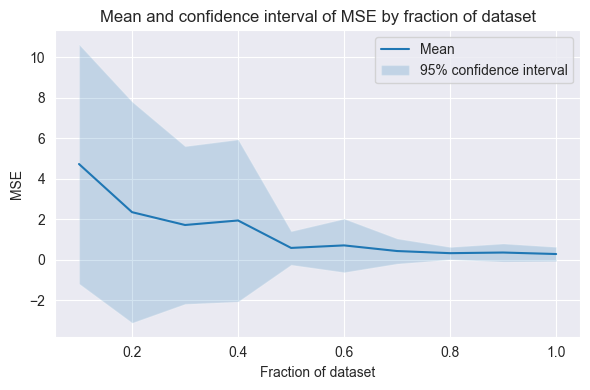

In [90]:
def gen_sample_dataset(data, frac):
    data = data.copy()
    return data.sample(frac=frac).sort_values(by='t').reset_index(drop=True)

def batch_comparison_by_frac(fracs, n_samples=10, optimizer=classic_annealing, objective=mse_objective, initial_conditions=[y[0], x[0]], **kwargs):
    results = []
    with tqdm(total=len(fracs)*n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(objective, **kwargs).x
                print(f"params: {params}")
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                print(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
                mse.append(mean_squared_error(sample_data[['y', 'x']].values, sim_data))
                print(f"MSE: {mean_squared_error(sample_data[['y', 'x']].values, sim_data)}")
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

try:
    fracs = np.linspace(0.1, 1.0, 10)
    experiment_df = batch_comparison_by_frac(fracs=fracs, n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA)
except Exception as e:
    print(f"An error occurred: {e}")

plt.figure(figsize=(6, 4), layout='tight')
plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
plt.fill_between(experiment_df['frac'], experiment_df['conf_int'].apply(lambda x: x[0]), experiment_df['conf_int'].apply(lambda x: x[1]), alpha=0.2, label='95% confidence interval')
plt.title('Mean and confidence interval of MSE by fraction of dataset')
plt.xlabel('Fraction of dataset')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/frac_conf_mse_sa.png')
plt.show()

In [91]:
def mse_objective(params, data):
    initial_conditions = [data['y'].iloc[0], data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, data['t'])
    return mean_squared_error(data[['y', 'x']].values, sim_data)

def mae_objective(params, data):
    initial_conditions = [data['y'].iloc[0], data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, data['t'])
    return mean_absolute_error(data[['y', 'x']].values, sim_data)

In [92]:
def batch_comparison_by_frac(data, fracs, data_variable, n_samples=10,
                             optimizer=classic_annealing,
                             objective=mse_objective,
                             **kwargs):
    results = []
    with tqdm(total=len(fracs) * n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(lambda params: objective(params, sample_data), **kwargs).x
                print(f"params: {params}")
                initial_conditions = [sample_data['y'].iloc[0], sample_data['x'].iloc[0]]
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                print(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
                mse.append(mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]]))
                print(f"MSE: {mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]])}")
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

## Experiments and plots

  0%|          | 1/200 [00:01<05:17,  1.60s/it]

params: [1.03094497 0.52847436 1.60272981 0.95663476]
Minimum and Maximum of sim_data: 0.27665852725840395, 6.342061282105141
MSE: 0.08322951615930695


  1%|          | 2/200 [00:03<05:46,  1.75s/it]

params: [1.64893821 0.78220052 1.37528261 1.34274568]
Minimum and Maximum of sim_data: 0.11743557767405438, 7.074856477892265
MSE: 0.2384216715783316


  2%|▏         | 3/200 [00:05<05:39,  1.72s/it]

params: [0.90641087 0.55589584 1.82807304 1.00167606]
Minimum and Maximum of sim_data: 0.236231084778616, 4.29458560432646
MSE: 0.08095591724801497


  2%|▏         | 4/200 [00:06<05:04,  1.55s/it]

params: [1.42639932 0.65865241 1.06162623 0.57183447]
Minimum and Maximum of sim_data: 0.48285859102114953, 5.362525198335311
MSE: 0.07399505425708983


  2%|▎         | 5/200 [00:08<05:15,  1.62s/it]

params: [1.70611501 1.05395602 1.10584233 0.46699184]
Minimum and Maximum of sim_data: 0.3607686907737092, 3.8285501852300703
MSE: 0.07109299340127753


  3%|▎         | 6/200 [00:09<05:05,  1.57s/it]

params: [1.61639553 0.59020271 0.90527962 0.49072214]
Minimum and Maximum of sim_data: 0.6999448036089291, 4.8040481094726415
MSE: 0.08195284761489037


  4%|▎         | 7/200 [00:10<04:49,  1.50s/it]

params: [1.23460139 0.64215282 1.43934702 0.93528964]
Minimum and Maximum of sim_data: 0.33176087411274874, 5.618882426875921
MSE: 0.09047792026060415


  4%|▍         | 8/200 [00:12<04:42,  1.47s/it]

params: [1.14242943 0.80761769 1.48539561 0.76392822]
Minimum and Maximum of sim_data: 0.38525680084046604, 4.543937997597665
MSE: 0.07727087536695819


  4%|▍         | 9/200 [00:13<04:45,  1.50s/it]

params: [1.15218761 0.55703314 1.436526   0.67453714]
Minimum and Maximum of sim_data: 0.5057051683260289, 6.002964955579773
MSE: 0.18529103368453673


  5%|▌         | 10/200 [00:15<05:01,  1.59s/it]

params: [1.15921091 0.68176569 1.75164172 1.10560336]
Minimum and Maximum of sim_data: 0.17725146520427235, 6.114004609747
MSE: 0.16228548166260554


  6%|▌         | 11/200 [00:17<04:57,  1.58s/it]

params: [0.98160451 0.47734541 1.72509721 1.01027107]
Minimum and Maximum of sim_data: 0.4190407115433911, 6.126408727538916
MSE: 0.011184580663689764


  6%|▌         | 12/200 [00:19<05:13,  1.67s/it]

params: [1.00334342 0.66611836 1.74306574 0.867532  ]
Minimum and Maximum of sim_data: 0.19481966233702586, 4.78163509155479
MSE: 0.07960414708237351


  6%|▋         | 13/200 [00:20<05:02,  1.62s/it]

params: [1.44460965 0.93349394 1.07767643 0.65814952]
Minimum and Maximum of sim_data: 0.5451267132401109, 3.590987314711149
MSE: 0.06627217094870784


  7%|▋         | 14/200 [00:22<05:05,  1.64s/it]

params: [1.13542478 0.94826938 1.79168017 1.12261076]
Minimum and Maximum of sim_data: 0.1495204327392924, 4.5251342898656475
MSE: 0.17386119871079075


  8%|▊         | 15/200 [00:23<05:00,  1.62s/it]

params: [1.43336508 0.75981466 1.20404069 0.76030607]
Minimum and Maximum of sim_data: 0.31562139520609894, 4.815115782464374
MSE: 0.18831513013860485


  8%|▊         | 16/200 [00:25<05:01,  1.64s/it]

params: [0.90559602 0.50683925 1.87369616 1.04712272]
Minimum and Maximum of sim_data: 0.37116599743966194, 5.088394966804658
MSE: 0.01801887459632154


  8%|▊         | 17/200 [00:27<04:56,  1.62s/it]

params: [1.44890137 0.80901137 1.22382296 0.72747148]
Minimum and Maximum of sim_data: 0.3204323372116215, 5.259703076298574
MSE: 0.4076798207888429


  9%|▉         | 18/200 [00:28<04:54,  1.62s/it]

params: [0.89037351 0.56527165 1.77105653 1.26032813]
Minimum and Maximum of sim_data: 0.2302089242367919, 5.195731675674719
MSE: 0.13349963665919307


 10%|▉         | 19/200 [00:30<04:51,  1.61s/it]

params: [1.14621548 0.53530852 1.46644835 0.89185829]
Minimum and Maximum of sim_data: 0.47227379944305126, 5.766974935796495
MSE: 0.04501190078745306


 10%|█         | 20/200 [00:32<04:53,  1.63s/it]

params: [0.88701348 0.4049074  1.8088902  0.98096092]
Minimum and Maximum of sim_data: 0.5021876144332611, 5.870098061597289
MSE: 0.029070967872680663


 10%|█         | 21/200 [00:33<04:46,  1.60s/it]

params: [1.05420814 0.49942162 1.63154244 0.8108267 ]
Minimum and Maximum of sim_data: 0.3652232723236143, 6.296186248127024
MSE: 0.17502577853370377


 11%|█         | 22/200 [00:35<04:55,  1.66s/it]

params: [1.0429299  0.48087254 1.68931455 1.07239191]
Minimum and Maximum of sim_data: 0.39867934483089673, 6.114004609747
MSE: 0.024278764400106758


 12%|█▏        | 23/200 [00:37<04:56,  1.68s/it]

params: [1.31327993 0.71600914 1.68531084 1.57314116]
Minimum and Maximum of sim_data: 0.12208397938008514, 7.135313060629415
MSE: 0.573675689703704


 12%|█▏        | 24/200 [00:38<04:56,  1.68s/it]

params: [1.07970789 0.57990034 1.5708531  0.89603783]
Minimum and Maximum of sim_data: 0.3102125486457102, 5.742495774413064
MSE: 0.1660312619849709


 12%|█▎        | 25/200 [00:40<04:56,  1.69s/it]

params: [1.31034461 0.88872698 1.21831241 0.66776758]
Minimum and Maximum of sim_data: 0.3962319559508178, 4.548931256667329
MSE: 0.13125754945355655


 13%|█▎        | 26/200 [00:42<04:50,  1.67s/it]

params: [0.97062917 0.5574605  1.82168996 1.02959937]
Minimum and Maximum of sim_data: 0.27565597268214026, 4.598133964506989
MSE: 0.031390930259197966


 14%|█▎        | 27/200 [00:43<04:55,  1.71s/it]

params: [0.78025245 0.35516549 1.99627092 0.98854382]
Minimum and Maximum of sim_data: 0.5464236616664173, 5.660504093696144
MSE: 0.0975465184429501


 14%|█▍        | 28/200 [00:45<04:41,  1.63s/it]

params: [1.17369835 0.60533395 1.43781004 0.76610933]
Minimum and Maximum of sim_data: 0.4207684346231595, 5.304188940630187
MSE: 0.12015215235091725


 14%|█▍        | 29/200 [00:47<04:43,  1.66s/it]

params: [1.12013243 0.93369282 1.78851239 1.22018501]
Minimum and Maximum of sim_data: 0.15299539648731095, 4.09324189416817
MSE: 0.14240921883012667


 15%|█▌        | 30/200 [00:48<04:33,  1.61s/it]

params: [1.47187094 0.61365487 0.972549   0.58206714]
Minimum and Maximum of sim_data: 0.48300236115241535, 4.940066211790521
MSE: 0.22385737389970264


 16%|█▌        | 31/200 [00:50<04:32,  1.61s/it]

params: [0.88964835 0.43388984 1.8743003  1.17289414]
Minimum and Maximum of sim_data: 0.3948419185293394, 5.730109702279888
MSE: 0.028990272684702178


 16%|█▌        | 32/200 [00:52<04:43,  1.69s/it]

params: [1.32101571 0.72012749 1.68107587 1.6289178 ]
Minimum and Maximum of sim_data: 0.1070848432516527, 7.574500867191428
MSE: 0.6645669070605986


 16%|█▋        | 33/200 [00:54<04:56,  1.77s/it]

params: [0.81519828 0.31898079 1.91064921 1.06144564]
Minimum and Maximum of sim_data: 0.7192641673426452, 6.2991231314458265
MSE: 0.11710338864652223


 17%|█▋        | 34/200 [00:55<04:50,  1.75s/it]

params: [1.29435849 0.6466886  1.43611938 0.88649595]
Minimum and Maximum of sim_data: 0.2942997153029916, 6.23836095039208
MSE: 0.12085465846987509


 18%|█▊        | 35/200 [00:57<04:41,  1.70s/it]

params: [1.13525039 0.57961825 1.44588641 0.82798533]
Minimum and Maximum of sim_data: 0.47944568681611094, 4.939742697941582
MSE: 0.017229953694679646


 18%|█▊        | 36/200 [00:59<04:36,  1.69s/it]

params: [0.99678222 0.61203578 1.81884461 1.04946918]
Minimum and Maximum of sim_data: 0.24684479830764275, 5.224967458095037
MSE: 0.06379542610542646


 18%|█▊        | 37/200 [01:00<04:32,  1.67s/it]

params: [1.27753891 0.7719453  1.46819952 1.09020561]
Minimum and Maximum of sim_data: 0.30918500113432057, 4.58254574572571
MSE: 0.15862840055822305


 19%|█▉        | 38/200 [01:02<04:27,  1.65s/it]

params: [1.37800984 1.07983804 1.46558461 0.78957303]
Minimum and Maximum of sim_data: 0.17925984841782458, 5.175395514050829
MSE: 0.32671732477769067


 20%|█▉        | 39/200 [01:03<04:13,  1.58s/it]

params: [0.89994904 0.4793291  1.93488173 1.11368652]
Minimum and Maximum of sim_data: 0.28866921602706397, 5.784087428178373
MSE: 0.013129628317260764


 20%|██        | 40/200 [01:05<04:23,  1.65s/it]

params: [0.86181661 0.41294613 1.88366781 0.98920207]
Minimum and Maximum of sim_data: 0.46228802608550246, 5.748624028991373
MSE: 0.03164166997929412


 20%|██        | 41/200 [01:07<04:31,  1.71s/it]

params: [1.44044334 0.74054794 1.25411883 0.81691509]
Minimum and Maximum of sim_data: 0.2819862010763493, 5.533642157583945
MSE: 0.21968180812270252


 21%|██        | 42/200 [01:08<04:26,  1.69s/it]

params: [1.35515706 0.55482673 1.26554554 0.82992591]
Minimum and Maximum of sim_data: 0.3507556652968802, 6.382806799783505
MSE: 0.09131452557208619


 22%|██▏       | 43/200 [01:10<04:29,  1.72s/it]

params: [1.42265183 0.75413912 1.30620772 0.89299701]
Minimum and Maximum of sim_data: 0.23156183683767464, 5.655103618182055
MSE: 0.20226928602667296


 22%|██▏       | 44/200 [01:12<04:28,  1.72s/it]

params: [1.13419499 0.49211391 1.48636576 0.92270371]
Minimum and Maximum of sim_data: 0.45850214012704177, 6.247163455464251
MSE: 0.02825276278595755


 22%|██▎       | 45/200 [01:14<04:25,  1.72s/it]

params: [1.3461097  0.85628052 1.35400443 0.7034049 ]
Minimum and Maximum of sim_data: 0.32619964772557625, 4.356570586495074
MSE: 0.08388884817965647


 23%|██▎       | 46/200 [01:16<04:31,  1.76s/it]

params: [1.43609292 0.73661731 1.44290707 1.12125038]
Minimum and Maximum of sim_data: 0.1726462420950675, 6.568221381436903
MSE: 0.27132479574417456


 24%|██▎       | 47/200 [01:17<04:37,  1.81s/it]

params: [1.18977465 0.54118279 1.64271104 1.41097647]
Minimum and Maximum of sim_data: 0.2361298432709225, 7.242267708828692
MSE: 0.31540142692107465


 24%|██▍       | 48/200 [01:19<04:42,  1.86s/it]

params: [1.10818883 0.66189377 1.72510996 1.12942523]
Minimum and Maximum of sim_data: 0.19348342616574588, 5.916426897719661
MSE: 0.10850037244463853


 24%|██▍       | 49/200 [01:21<04:42,  1.87s/it]

params: [1.0516987  0.49009047 1.62558082 0.98784008]
Minimum and Maximum of sim_data: 0.4492824102798646, 5.52052404752254
MSE: 0.014118459786573929


 25%|██▌       | 50/200 [01:23<04:42,  1.89s/it]

params: [1.34200592 0.6004069  1.33001845 0.96327059]
Minimum and Maximum of sim_data: 0.29013531443022667, 6.274022634897373
MSE: 0.16389406965604217


 26%|██▌       | 51/200 [01:25<04:44,  1.91s/it]

params: [1.3125637  0.77854642 1.70852553 1.59034192]
Minimum and Maximum of sim_data: 0.10943356185691412, 7.095012500503026
MSE: 0.5616064456625754


 26%|██▌       | 52/200 [01:27<04:40,  1.89s/it]

params: [1.23886898 0.52576003 1.63394759 1.47479046]
Minimum and Maximum of sim_data: 0.1812574739659183, 6.778576811288118
MSE: 0.3665947178994001


 26%|██▋       | 53/200 [01:29<04:25,  1.81s/it]

params: [0.93890939 0.48213583 1.86387862 1.00979287]
Minimum and Maximum of sim_data: 0.2959511808889003, 6.115791144305534
MSE: 0.03760601369081762


 27%|██▋       | 54/200 [01:30<04:23,  1.80s/it]

params: [0.9400167  0.40422993 1.80316314 1.14436404]
Minimum and Maximum of sim_data: 0.48576268398258654, 6.476220660956238
MSE: 0.04362595852585229


 28%|██▊       | 55/200 [01:32<04:22,  1.81s/it]

params: [1.56271167 0.91426565 1.22125246 0.79981344]
Minimum and Maximum of sim_data: 0.24748918161082203, 4.778204486991222
MSE: 0.26955047055722753


 28%|██▊       | 56/200 [01:34<04:19,  1.80s/it]

params: [1.20355539 0.5520059  1.44956618 0.99844847]
Minimum and Maximum of sim_data: 0.34623603501513966, 6.23836095039208
MSE: 0.1225497704869795


 28%|██▊       | 57/200 [01:36<04:14,  1.78s/it]

params: [1.10846426 0.50398907 1.48784375 0.73153349]
Minimum and Maximum of sim_data: 0.5935834461296747, 5.5161469660714
MSE: 0.28610462131760134


 29%|██▉       | 58/200 [01:38<04:16,  1.80s/it]

params: [1.16325305 0.71002162 1.87567514 1.5721219 ]
Minimum and Maximum of sim_data: 0.10630387087247002, 7.022331500788838
MSE: 0.28295919560737504


 30%|██▉       | 59/200 [01:40<04:18,  1.83s/it]

params: [1.2296154  0.79656588 1.66390264 1.14931131]
Minimum and Maximum of sim_data: 0.14714184016451812, 5.812845327778346
MSE: 0.2281363427658448


 30%|███       | 60/200 [01:41<04:08,  1.78s/it]

params: [1.48752633 0.88530962 1.20783065 0.74191166]
Minimum and Maximum of sim_data: 0.3730339016068165, 4.384811873854695
MSE: 0.11300323986554026


 30%|███       | 61/200 [01:43<04:06,  1.77s/it]

params: [1.24419458 0.59965592 1.48595865 1.03769333]
Minimum and Maximum of sim_data: 0.2796450586397029, 6.264359359726292
MSE: 0.1484157440563152


 31%|███       | 62/200 [01:45<04:05,  1.78s/it]

params: [0.96716514 0.51542288 1.86413596 1.11959472]
Minimum and Maximum of sim_data: 0.2536904912635734, 6.23836095039208
MSE: 0.03309816178558156


 32%|███▏      | 63/200 [01:47<04:11,  1.84s/it]

params: [1.08715588 0.67834709 1.9179875  1.43959329]
Minimum and Maximum of sim_data: 0.11709004672241631, 6.568072730926606
MSE: 0.242746380541963


 32%|███▏      | 64/200 [01:49<04:08,  1.83s/it]

params: [1.21233849 0.52351216 1.4061689  0.93043853]
Minimum and Maximum of sim_data: 0.3979829630171998, 6.1676647916253655
MSE: 0.08016898470799194


 32%|███▎      | 65/200 [01:50<04:03,  1.81s/it]

params: [1.25929992 0.70287705 1.3991426  0.79203807]
Minimum and Maximum of sim_data: 0.3268624811121633, 5.306944646526979
MSE: 0.12123307014826576


 33%|███▎      | 66/200 [01:52<04:01,  1.81s/it]

params: [1.16571966 0.59406677 1.48889596 0.9049966 ]
Minimum and Maximum of sim_data: 0.3764369293782244, 5.69584164933218
MSE: 0.05286993109825986


 34%|███▎      | 67/200 [01:54<04:01,  1.82s/it]

params: [1.51634283 1.01687792 1.40847377 0.99976367]
Minimum and Maximum of sim_data: 0.12546491478139435, 5.476000111427085
MSE: 0.4961807360414417


 34%|███▍      | 68/200 [01:56<03:55,  1.79s/it]

params: [1.00077247 0.39639869 1.58531848 0.88995011]
Minimum and Maximum of sim_data: 0.6617731371286993, 6.268299716207282
MSE: 0.020402948328470935


 34%|███▍      | 69/200 [01:58<03:58,  1.82s/it]

params: [1.535049   1.17305544 1.54508956 1.15046532]
Minimum and Maximum of sim_data: 0.08440048650323154, 5.691405833762695
MSE: 0.7694184616844812


 35%|███▌      | 70/200 [01:59<03:50,  1.77s/it]

params: [1.10845982 0.56410665 1.67682529 1.65943233]
Minimum and Maximum of sim_data: 0.21614476806025784, 6.579014007502665
MSE: 0.794397177377946


 36%|███▌      | 71/200 [02:01<03:51,  1.79s/it]

params: [1.12931408 0.57155963 1.62794422 1.12245276]
Minimum and Maximum of sim_data: 0.2996124162781722, 6.249963353387471
MSE: 0.09356938998373032


 36%|███▌      | 72/200 [02:03<03:43,  1.75s/it]

params: [1.48987    0.6583635  1.16238773 0.65499931]
Minimum and Maximum of sim_data: 0.34991893547831926, 5.930075511916386
MSE: 0.2126332028673043


 36%|███▋      | 73/200 [02:05<03:45,  1.77s/it]

params: [1.18979587 0.69118544 1.71442939 1.34972427]
Minimum and Maximum of sim_data: 0.15423356036973, 6.627583618182021
MSE: 0.34119287083023175


 37%|███▋      | 74/200 [02:06<03:43,  1.78s/it]

params: [1.03445991 0.49480827 1.61493686 0.7916183 ]
Minimum and Maximum of sim_data: 0.39787148054718086, 6.12637338659502
MSE: 0.23280533838626125


 38%|███▊      | 75/200 [02:08<03:45,  1.81s/it]

params: [1.54288702 0.73614141 1.32065876 1.24315236]
Minimum and Maximum of sim_data: 0.11382717916081686, 7.010381486439437
MSE: 0.49225502924534714


 38%|███▊      | 76/200 [02:10<03:43,  1.80s/it]

params: [0.92089624 0.4063954  1.71997594 0.93834509]
Minimum and Maximum of sim_data: 0.5593479375475015, 5.875042403297232
MSE: 0.04346880474243533


 38%|███▊      | 77/200 [02:12<03:42,  1.81s/it]

params: [1.15378094 0.71414682 1.7588083  1.28742284]
Minimum and Maximum of sim_data: 0.1419114463668516, 6.237213801400226
MSE: 0.2141382330701294


 39%|███▉      | 78/200 [02:14<03:35,  1.77s/it]

params: [1.39153464 0.54825904 1.19826184 0.6875677 ]
Minimum and Maximum of sim_data: 0.4214330888022766, 6.23836095039208
MSE: 0.08607608378875523


 40%|███▉      | 79/200 [02:15<03:35,  1.78s/it]

params: [1.30775939 0.70612428 1.42439353 1.00510799]
Minimum and Maximum of sim_data: 0.23815130827987838, 5.952110854563202
MSE: 0.20931788528394604


 40%|████      | 80/200 [02:17<03:38,  1.82s/it]

params: [1.05897744 0.82448145 1.9935909  1.2617727 ]
Minimum and Maximum of sim_data: 0.07388810619793179, 5.62243488707021
MSE: 0.2280824101967188


 40%|████      | 81/200 [02:19<03:28,  1.75s/it]

params: [1.5550117  0.48105839 0.98464623 0.7071579 ]
Minimum and Maximum of sim_data: 0.46403860988140594, 6.23836095039208
MSE: 0.16328079378868998


 41%|████      | 82/200 [02:21<03:31,  1.80s/it]

params: [1.18164495 0.9160581  1.96004838 1.48439216]
Minimum and Maximum of sim_data: 0.056602854390306066, 6.090863122240118
MSE: 0.39155646959834217


 42%|████▏     | 83/200 [02:23<03:33,  1.82s/it]

params: [1.0646445  0.51879689 1.57979545 0.90768053]
Minimum and Maximum of sim_data: 0.4367238844405492, 5.704382002015143
MSE: 0.013713796431001584


 42%|████▏     | 84/200 [02:24<03:28,  1.80s/it]

params: [1.31836672 0.60712586 1.35740259 0.83617747]
Minimum and Maximum of sim_data: 0.32553174928269824, 6.234090916450496
MSE: 0.1080173001519443


 42%|████▎     | 85/200 [02:26<03:26,  1.80s/it]

params: [1.70877508 0.80113476 1.14706618 0.77425272]
Minimum and Maximum of sim_data: 0.17220804625275082, 6.23836095039208
MSE: 0.31076547773703955


 43%|████▎     | 86/200 [02:28<03:28,  1.83s/it]

params: [1.94439245 0.96881858 0.91729752 0.49097787]
Minimum and Maximum of sim_data: 0.22727561481083808, 6.475509342982901
MSE: 0.7447612698165343


 44%|████▎     | 87/200 [02:30<03:28,  1.85s/it]

params: [1.22095542 0.84637652 1.84072368 1.30281018]
Minimum and Maximum of sim_data: 0.0876489337887746, 6.23836095039208
MSE: 0.38627020847907984


 44%|████▍     | 88/200 [02:32<03:27,  1.85s/it]

params: [1.9514549  1.1240729  1.23112572 1.03259592]
Minimum and Maximum of sim_data: 0.055823187415654514, 6.23836095039208
MSE: 0.7979750950383785


 44%|████▍     | 89/200 [02:34<03:24,  1.84s/it]

params: [1.39842254 0.58977155 1.26077744 0.91997744]
Minimum and Maximum of sim_data: 0.3045265239841098, 6.23836095039208
MSE: 0.17685121273577567


 45%|████▌     | 90/200 [02:36<03:24,  1.86s/it]

params: [1.66443113 0.6325418  0.99883019 0.51735321]
Minimum and Maximum of sim_data: 0.3864867332178814, 6.131253454600371
MSE: 0.33796965870444107


 46%|████▌     | 91/200 [02:37<03:17,  1.81s/it]

params: [1.03629664 0.40651818 1.53564812 0.87937829]
Minimum and Maximum of sim_data: 0.6264803014181529, 6.3172412324067455
MSE: 0.025539974122745467


 46%|████▌     | 92/200 [02:39<03:16,  1.82s/it]

params: [1.11863281 0.7125103  1.86124438 1.18929516]
Minimum and Maximum of sim_data: 0.12107089352032434, 6.334745330005714
MSE: 0.19205711606233636


 46%|████▋     | 93/200 [02:41<03:15,  1.82s/it]

params: [0.96627876 0.50835377 1.99521607 1.48182911]
Minimum and Maximum of sim_data: 0.1700751175703865, 7.291513697677206
MSE: 0.19270836002563357


C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 47%|████▋     | 94/200 [02:43<03:14,  1.84s/it]

params: [1.12554611 0.81640912 1.85904153 1.23211206]
Minimum and Maximum of sim_data: 0.09528106852851811, 5.745592570622948
MSE: 0.22934694899699493


 48%|████▊     | 95/200 [02:45<03:11,  1.83s/it]

params: [0.96710181 0.46165693 1.75006232 1.08134847]
Minimum and Maximum of sim_data: 0.37771505802335664, 6.26084233004249
MSE: 0.03898036721657587


 48%|████▊     | 96/200 [02:46<03:06,  1.80s/it]

params: [1.73963332 0.79068391 1.11621514 0.77348793]
Minimum and Maximum of sim_data: 0.16623126180958445, 6.333129089932932
MSE: 0.30479162278216526


 48%|████▊     | 97/200 [02:48<03:00,  1.75s/it]

params: [0.92721599 0.47325509 1.82219993 0.94855645]
Minimum and Maximum of sim_data: 0.36284600199341466, 5.752901541414162
MSE: 0.03626232125911863


 49%|████▉     | 98/200 [02:50<03:01,  1.78s/it]

params: [0.90454736 0.4786918  1.93479935 1.15118338]
Minimum and Maximum of sim_data: 0.2786707326783849, 6.028566944517163
MSE: 0.016538643274315732


 50%|████▉     | 99/200 [02:52<03:03,  1.82s/it]

params: [1.32080442 0.82125601 1.66078323 1.42041387]
Minimum and Maximum of sim_data: 0.11739488185455303, 6.360989411147945
MSE: 0.42062157963941355


 50%|█████     | 100/200 [02:53<02:59,  1.79s/it]

params: [1.06833017 0.55431508 1.74457763 1.20760693]
Minimum and Maximum of sim_data: 0.254127046139561, 6.502782491545031
MSE: 0.10239304408690283


 50%|█████     | 101/200 [02:55<03:00,  1.82s/it]

params: [1.22141354 0.65491851 1.52253495 0.9725878 ]
Minimum and Maximum of sim_data: 0.30779882969030903, 5.775013467438114
MSE: 0.1775248973180213


 51%|█████     | 102/200 [02:57<02:58,  1.82s/it]

params: [1.28493113 0.65475146 1.47865421 1.06285038]
Minimum and Maximum of sim_data: 0.22852034629330023, 6.480691787761633
MSE: 0.22042693094647203


 52%|█████▏    | 103/200 [02:59<02:57,  1.83s/it]

params: [1.25593129 0.5536038  1.27305602 0.7088507 ]
Minimum and Maximum of sim_data: 0.525116945923609, 5.464483472879802
MSE: 0.03593172591931595


 52%|█████▏    | 104/200 [03:01<02:59,  1.87s/it]

params: [1.42788165 0.8072495  1.44160736 1.18097239]
Minimum and Maximum of sim_data: 0.1404012898070828, 6.295663990967933
MSE: 0.3809719786095541


 52%|█████▎    | 105/200 [03:03<02:53,  1.83s/it]

params: [0.96492392 0.48588441 1.88436541 1.29944941]
Minimum and Maximum of sim_data: 0.26574435698149534, 6.662535003698491
MSE: 0.10723651581311877


 53%|█████▎    | 106/200 [03:04<02:49,  1.80s/it]

params: [0.96211312 0.45879702 1.66527496 0.8625724 ]
Minimum and Maximum of sim_data: 0.5060327550670038, 5.514840462351899
MSE: 0.0440116715910678


 54%|█████▎    | 107/200 [03:06<02:52,  1.85s/it]

params: [1.32578269 0.72173087 1.33149095 0.78568563]
Minimum and Maximum of sim_data: 0.3219884893210267, 5.378822410412519
MSE: 0.15207794084040058


 54%|█████▍    | 108/200 [03:08<02:50,  1.85s/it]

params: [1.2980209  0.56860144 1.2995935  0.8642404 ]
Minimum and Maximum of sim_data: 0.35917655854202685, 6.02696501447956
MSE: 0.10341546485574434


 55%|█████▍    | 109/200 [03:10<02:47,  1.84s/it]

params: [0.97700118 0.52130966 1.68052944 0.88587428]
Minimum and Maximum of sim_data: 0.3628491971616486, 5.393023258013818
MSE: 0.06932688342296056


 55%|█████▌    | 110/200 [03:12<02:46,  1.85s/it]

params: [1.48996937 0.80896409 1.41877828 1.10245239]
Minimum and Maximum of sim_data: 0.1371216185793679, 6.534705001675865
MSE: 0.3694735518662032


 56%|█████▌    | 111/200 [03:14<02:43,  1.84s/it]

params: [0.95344549 0.53034644 1.92185991 1.23731414]
Minimum and Maximum of sim_data: 0.21231278867402978, 6.308197591334732
MSE: 0.06449148707013536


 56%|█████▌    | 112/200 [03:16<02:42,  1.84s/it]

params: [1.56209232 0.68559374 1.11914622 0.76185559]
Minimum and Maximum of sim_data: 0.2834768678874803, 5.761124398009121
MSE: 0.14655689073667408


 56%|█████▋    | 113/200 [03:18<02:43,  1.87s/it]

params: [0.98070854 0.55174826 1.97232108 1.38607354]
Minimum and Maximum of sim_data: 0.16763001973747196, 6.711804589545524
MSE: 0.13003206001490428


 57%|█████▋    | 114/200 [03:19<02:40,  1.86s/it]

params: [1.70124254 0.96550835 1.18191743 0.88553213]
Minimum and Maximum of sim_data: 0.12232062304920659, 5.604281633045277
MSE: 0.45806016467736843


 57%|█████▊    | 115/200 [03:21<02:36,  1.85s/it]

params: [1.7090621  0.75174917 1.10729311 0.77034442]
Minimum and Maximum of sim_data: 0.18473786882637264, 6.349131134845398
MSE: 0.31662389648291317


 58%|█████▊    | 116/200 [03:23<02:33,  1.83s/it]

params: [1.48710537 0.69594869 1.11868474 0.63985377]
Minimum and Maximum of sim_data: 0.3725945450550989, 5.296624302424916
MSE: 0.15018680982202046


 58%|█████▊    | 117/200 [03:25<02:26,  1.77s/it]

params: [1.00217376 0.683475   1.74665963 1.16243443]
Minimum and Maximum of sim_data: 0.2708592961816017, 4.345948569114938
MSE: 0.10710483648746476


 59%|█████▉    | 118/200 [03:27<02:29,  1.82s/it]

params: [1.54842595 1.14587903 1.66155746 1.51850393]
Minimum and Maximum of sim_data: 0.06106241072109482, 6.232578918762822
MSE: 0.6069725538568508


 60%|█████▉    | 119/200 [03:28<02:26,  1.81s/it]

params: [0.98066002 0.43735424 1.65688777 0.87477896]
Minimum and Maximum of sim_data: 0.4881699322633268, 6.151819194415654
MSE: 0.03265603071236319


 60%|██████    | 120/200 [03:30<02:26,  1.83s/it]

params: [1.93440238 0.93056141 1.09005996 1.07183034]
Minimum and Maximum of sim_data: 0.07189512199100415, 6.429461893323011
MSE: 0.6570452747365338


 60%|██████    | 121/200 [03:32<02:25,  1.85s/it]

params: [1.4504873  0.67859031 1.31771336 1.08267874]
Minimum and Maximum of sim_data: 0.18078918365305677, 6.594882075986985
MSE: 0.3405622055978917


 61%|██████    | 122/200 [03:34<02:24,  1.85s/it]

params: [1.4122968  0.94955584 1.59164384 1.33411095]
Minimum and Maximum of sim_data: 0.102593186665428, 6.172324911791423
MSE: 0.5238238943251139


 62%|██████▏   | 123/200 [03:36<02:22,  1.85s/it]

params: [1.11231164 0.66090467 1.94090708 1.64362472]
Minimum and Maximum of sim_data: 0.09923911315408301, 7.3060126272560915
MSE: 0.4123205104727754


 62%|██████▏   | 124/200 [03:38<02:18,  1.82s/it]

params: [0.96584129 0.45313102 1.76383687 1.04718641]
Minimum and Maximum of sim_data: 0.38913210546693633, 6.297822047291479
MSE: 0.012003739282608018


 62%|██████▎   | 125/200 [03:39<02:14,  1.80s/it]

params: [0.88186533 0.44893823 1.95531312 1.11380994]
Minimum and Maximum of sim_data: 0.2987402080631213, 6.256034118542627
MSE: 0.010873975023622787


 63%|██████▎   | 126/200 [03:41<02:10,  1.76s/it]

params: [1.46042438 0.56489342 1.03052824 0.51066013]
Minimum and Maximum of sim_data: 0.6763051245721506, 5.139150656430109
MSE: 0.10674748340526181


 64%|██████▎   | 127/200 [03:43<02:11,  1.80s/it]

params: [1.69271423 0.81607854 1.06034477 0.68679057]
Minimum and Maximum of sim_data: 0.23342549782470043, 5.414032680234978
MSE: 0.24881696723712424


 64%|██████▍   | 128/200 [03:45<02:08,  1.78s/it]

params: [0.9097248  0.4268421  1.81612341 0.99277815]
Minimum and Maximum of sim_data: 0.40576789106867206, 6.225705779816441
MSE: 0.017680086764964298


 64%|██████▍   | 129/200 [03:46<02:06,  1.78s/it]

params: [1.08547041 0.62192205 1.78182247 1.08718947]
Minimum and Maximum of sim_data: 0.1942874211814171, 6.23836095039208
MSE: 0.09457770179988974


 65%|██████▌   | 130/200 [03:48<02:08,  1.83s/it]

params: [1.63384241 0.79329905 1.11818334 0.82702554]
Minimum and Maximum of sim_data: 0.18277843945223413, 5.788112019951449
MSE: 0.3673770963299455


 66%|██████▌   | 131/200 [03:50<02:06,  1.83s/it]

params: [1.27689664 0.74748248 1.6338205  1.33412537]
Minimum and Maximum of sim_data: 0.1535411821390486, 6.5717399952198425
MSE: 0.3431643890400868


 66%|██████▌   | 132/200 [03:52<02:04,  1.83s/it]

params: [1.39474259 0.81582715 1.46527105 1.13553506]
Minimum and Maximum of sim_data: 0.15699358218931453, 6.079416716706981
MSE: 0.34317227223248187


 66%|██████▋   | 133/200 [03:54<02:03,  1.84s/it]

params: [1.391925   0.88052586 1.64261516 1.34515395]
Minimum and Maximum of sim_data: 0.10698596906774697, 6.632345224963148
MSE: 0.48181452923645285


 67%|██████▋   | 134/200 [03:56<02:00,  1.83s/it]

params: [0.9966106  0.4714304  1.91596051 1.41705385]
Minimum and Maximum of sim_data: 0.24133557875492337, 7.50333114238121
MSE: 0.16062518697915878


 68%|██████▊   | 135/200 [03:58<01:59,  1.84s/it]

params: [1.70658361 0.81943026 1.05105464 0.6879257 ]
Minimum and Maximum of sim_data: 0.22716337556286736, 5.431480776029016
MSE: 0.2573345986242575


 68%|██████▊   | 136/200 [03:59<01:56,  1.82s/it]

params: [1.65180942 0.94721458 1.35563208 1.10602604]
Minimum and Maximum of sim_data: 0.0984720120283846, 6.23836095039208
MSE: 0.49307610378129546


 68%|██████▊   | 137/200 [04:01<01:56,  1.85s/it]

params: [1.23190624 0.92093241 1.97655476 1.70409632]
Minimum and Maximum of sim_data: 0.048649728995702135, 6.6073964144947155
MSE: 0.5446112055446642


 69%|██████▉   | 138/200 [04:03<01:56,  1.87s/it]

params: [1.39980201 0.74116849 1.46862886 1.25721399]
Minimum and Maximum of sim_data: 0.14448442795896022, 6.688476963797691
MSE: 0.41640763595095925


 70%|██████▉   | 139/200 [04:05<01:53,  1.86s/it]

params: [1.15238075 0.69969645 1.82250584 1.43376635]
Minimum and Maximum of sim_data: 0.12606920068015687, 6.678044916238718
MSE: 0.28340818727800327


 70%|███████   | 140/200 [04:07<01:50,  1.83s/it]

params: [0.80484052 0.39303671 1.9235299  0.9085602 ]
Minimum and Maximum of sim_data: 0.49443910531193197, 5.334838325999709
MSE: 0.17432826891092998


 70%|███████   | 141/200 [04:09<01:49,  1.86s/it]

params: [1.85721497 0.91868056 1.17125943 1.05927091]
Minimum and Maximum of sim_data: 0.07552216440767931, 6.656857852099655
MSE: 0.643631186544579


 71%|███████   | 142/200 [04:10<01:47,  1.85s/it]

params: [1.88378217 0.83870426 1.0024264  0.80158591]
Minimum and Maximum of sim_data: 0.1497910758474081, 5.897849744722489
MSE: 0.37906593626523677


 72%|███████▏  | 143/200 [04:12<01:45,  1.86s/it]

params: [1.39842119 0.96191654 1.55111848 1.14274915]
Minimum and Maximum of sim_data: 0.12008500910948794, 5.742758829001658
MSE: 0.4311106248985773


 72%|███████▏  | 144/200 [04:14<01:44,  1.86s/it]

params: [1.21569032 0.71779715 1.82319105 1.62841727]
Minimum and Maximum of sim_data: 0.1036767005398114, 7.314228487707395
MSE: 0.4697065122498154


 72%|███████▎  | 145/200 [04:16<01:43,  1.89s/it]

params: [0.94295758 0.57826935 1.85752895 0.87486128]
Minimum and Maximum of sim_data: 0.2590117454244387, 5.126876357806957
MSE: 0.3309033301900017


 73%|███████▎  | 146/200 [04:18<01:42,  1.90s/it]

params: [0.77233562 0.27667526 1.96304691 0.96022131]
Minimum and Maximum of sim_data: 0.9740688187430628, 6.087530822084123
MSE: 0.2326172925455318


 74%|███████▎  | 147/200 [04:20<01:40,  1.89s/it]

params: [1.07202607 0.43570387 1.52473087 0.97481691]
Minimum and Maximum of sim_data: 0.49480555717718183, 6.4788197351944286
MSE: 0.06275234751056133


 74%|███████▍  | 148/200 [04:22<01:35,  1.84s/it]

params: [0.82112123 0.34176615 1.86969982 0.93765592]
Minimum and Maximum of sim_data: 0.6915406089025475, 5.806356342126264
MSE: 0.11834274005816263


 74%|███████▍  | 149/200 [04:24<01:35,  1.88s/it]

params: [1.35297867 0.73316769 1.70973334 1.7465192 ]
Minimum and Maximum of sim_data: 0.09041598759436881, 7.9691241500109085
MSE: 0.6865775581690077


 75%|███████▌  | 150/200 [04:26<01:35,  1.91s/it]

params: [1.45419048 1.03238437 1.69163716 1.1925858 ]
Minimum and Maximum of sim_data: 0.07391082006287629, 6.329549420642125
MSE: 0.6419406909423924


 76%|███████▌  | 151/200 [04:27<01:31,  1.86s/it]

params: [0.74649669 0.35785365 1.97366529 0.85910843]
Minimum and Maximum of sim_data: 0.566411266660296, 5.1863895660647605
MSE: 0.3476416672570858


 76%|███████▌  | 152/200 [04:29<01:29,  1.87s/it]

params: [1.16328798 0.68605001 1.8514133  1.56297161]
Minimum and Maximum of sim_data: 0.1139300921926021, 7.138061575896307
MSE: 0.37005375152349573


 76%|███████▋  | 153/200 [04:31<01:26,  1.85s/it]

params: [1.19585568 0.60991869 1.41733156 0.74885427]
Minimum and Maximum of sim_data: 0.44902549419003573, 5.272041959811028
MSE: 0.10574074455484546


 77%|███████▋  | 154/200 [04:33<01:24,  1.85s/it]

params: [1.15505858 0.47124877 1.34195917 0.70795421]
Minimum and Maximum of sim_data: 0.6912808380777095, 5.4887014513847445
MSE: 0.0358345646245465


 78%|███████▊  | 155/200 [04:35<01:24,  1.88s/it]

params: [1.38619933 0.86064314 1.54493573 1.32839192]
Minimum and Maximum of sim_data: 0.11150039379071838, 6.420256148143466
MSE: 0.575039819533838


 78%|███████▊  | 156/200 [04:37<01:21,  1.86s/it]

params: [1.11217813 0.76135815 1.84704233 1.26665268]
Minimum and Maximum of sim_data: 0.10946266451117197, 5.938603537431721
MSE: 0.2053427475526593


 78%|███████▊  | 157/200 [04:39<01:23,  1.93s/it]

params: [1.28258891 0.85861077 1.49031165 0.80060156]
Minimum and Maximum of sim_data: 0.18723313029337804, 5.931663338804363
MSE: 0.4576680675960641


 79%|███████▉  | 158/200 [04:41<01:21,  1.93s/it]

params: [1.75989132 0.92713366 1.08550175 0.6978275 ]
Minimum and Maximum of sim_data: 0.18524769988257409, 5.441032550458294
MSE: 0.40488092997397507


 80%|███████▉  | 159/200 [04:43<01:18,  1.92s/it]

params: [1.30841818 0.65754094 1.50633711 1.24259937]
Minimum and Maximum of sim_data: 0.18338121826513132, 6.8326233194153065
MSE: 0.3436820714660515


 80%|████████  | 160/200 [04:44<01:15,  1.88s/it]

params: [1.62602332 0.68946271 1.06819443 0.75280407]
Minimum and Maximum of sim_data: 0.2643767437837899, 5.820982964845395
MSE: 0.1528148565935815


 80%|████████  | 161/200 [04:46<01:13,  1.90s/it]

params: [1.39983164 0.87422587 1.77478805 1.85966568]
Minimum and Maximum of sim_data: 0.06695865314075787, 7.601251036112906
MSE: 0.7667330233230165


 81%|████████  | 162/200 [04:48<01:12,  1.92s/it]

params: [1.84190589 1.29003429 1.33862011 1.14512875]
Minimum and Maximum of sim_data: 0.0491792457019789, 5.6934751556571594
MSE: 0.8132298850893297


 82%|████████▏ | 163/200 [04:50<01:09,  1.87s/it]

params: [0.97696    0.40921915 1.56847193 0.81240277]
Minimum and Maximum of sim_data: 0.7198325642592333, 5.625373011383592
MSE: 0.06716831674147312


 82%|████████▏ | 164/200 [04:52<01:07,  1.87s/it]

params: [1.17437167 0.77405848 1.76334865 1.25519979]
Minimum and Maximum of sim_data: 0.12352584953267734, 6.019923885853004
MSE: 0.23373251516390744


 82%|████████▎ | 165/200 [04:54<01:05,  1.89s/it]

params: [1.71201315 0.77286046 1.0083848  0.640847  ]
Minimum and Maximum of sim_data: 0.27066385715988533, 5.394514256647394
MSE: 0.18739530980207353


 83%|████████▎ | 166/200 [04:56<01:04,  1.90s/it]

params: [1.89542644 0.72859792 0.86176357 0.53756958]
Minimum and Maximum of sim_data: 0.3415593502882837, 5.397975392802574
MSE: 0.09857069649686705


 84%|████████▎ | 167/200 [04:58<01:03,  1.91s/it]

params: [1.76785144 1.14531942 1.34726634 1.27290352]
Minimum and Maximum of sim_data: 0.05107033424445906, 6.111410899521785
MSE: 0.7919910463714258


 84%|████████▍ | 168/200 [05:00<01:00,  1.88s/it]

params: [1.26980437 0.65676896 1.31275067 0.70147586]
Minimum and Maximum of sim_data: 0.43857503959565747, 5.230688778856096
MSE: 0.16690020281889978


 84%|████████▍ | 169/200 [05:01<00:57,  1.86s/it]

params: [1.03378775 0.56399146 1.66305814 0.9444562 ]
Minimum and Maximum of sim_data: 0.3132861341511238, 5.5996053177146194
MSE: 0.04167683661113472


 85%|████████▌ | 170/200 [05:03<00:54,  1.82s/it]

params: [1.37710857 0.72925084 1.43243218 0.97899417]
Minimum and Maximum of sim_data: 0.21472743282400983, 6.23836095039208
MSE: 0.25157535578886076


 86%|████████▌ | 171/200 [05:05<00:52,  1.82s/it]

params: [1.37043071 0.59777583 1.20274878 0.73672543]
Minimum and Maximum of sim_data: 0.4070601133444273, 5.6291128562623856
MSE: 0.05706197920863743


 86%|████████▌ | 172/200 [05:07<00:51,  1.83s/it]

params: [0.97435818 0.41058718 1.53315171 0.73246981]
Minimum and Maximum of sim_data: 0.7845275223516442, 5.304923806243674
MSE: 0.14757890217835495


 86%|████████▋ | 173/200 [05:09<00:49,  1.85s/it]

params: [1.53154297 0.9750872  1.54786878 1.47649677]
Minimum and Maximum of sim_data: 0.07151425001850643, 6.577951429514814
MSE: 0.6237983735984572


 87%|████████▋ | 174/200 [05:10<00:47,  1.84s/it]

params: [1.55253752 0.79993951 1.32009075 0.99283233]
Minimum and Maximum of sim_data: 0.1446237083357086, 6.464577042631229
MSE: 0.37286644492743704


 88%|████████▊ | 175/200 [05:12<00:45,  1.84s/it]

params: [0.95181915 0.51141059 1.66916587 0.73602017]
Minimum and Maximum of sim_data: 0.42356943975161304, 5.027540330674435
MSE: 0.33919024720014845


 88%|████████▊ | 176/200 [05:14<00:43,  1.83s/it]

params: [1.02058721 0.52497881 1.61764793 0.83970337]
Minimum and Maximum of sim_data: 0.4185086815135755, 5.384472430858989
MSE: 0.0629446982476225


 88%|████████▊ | 177/200 [05:16<00:41,  1.81s/it]

params: [0.98359804 0.57155177 1.88203802 1.19172312]
Minimum and Maximum of sim_data: 0.19960768694142605, 6.071685764193543
MSE: 0.05750584673515929


 89%|████████▉ | 178/200 [05:18<00:40,  1.83s/it]

params: [1.22885867 0.91716612 1.78962661 1.25609299]
Minimum and Maximum of sim_data: 0.08324512358543061, 5.761245266225221
MSE: 0.3444113822122316


 90%|████████▉ | 179/200 [05:20<00:38,  1.84s/it]

params: [0.99246113 0.56796192 1.91812889 1.29163143]
Minimum and Maximum of sim_data: 0.18207168430844622, 6.397217220759797
MSE: 0.09394358354151608


 90%|█████████ | 180/200 [05:21<00:36,  1.82s/it]

params: [1.49919658 0.87395471 1.25319524 0.75321974]
Minimum and Maximum of sim_data: 0.22658129713280942, 5.55617703293445
MSE: 0.3858857377283517


 90%|█████████ | 181/200 [05:23<00:34,  1.80s/it]

params: [1.53805135 0.70431328 1.18482811 0.88766144]
Minimum and Maximum of sim_data: 0.21701984869864885, 6.056209426364763
MSE: 0.23404659257393864


 91%|█████████ | 182/200 [05:25<00:32,  1.82s/it]

params: [1.17139593 0.57261564 1.61328848 1.23625644]
Minimum and Maximum of sim_data: 0.2526510200915241, 6.858192178860309
MSE: 0.222973065738986


 92%|█████████▏| 183/200 [05:27<00:31,  1.83s/it]

params: [1.75671533 0.98536729 1.17181072 0.92838494]
Minimum and Maximum of sim_data: 0.10499109312784204, 5.729643777448281
MSE: 0.5031950600917787


 92%|█████████▏| 184/200 [05:29<00:29,  1.83s/it]

params: [1.75350648 0.96217344 1.14825612 0.87566344]
Minimum and Maximum of sim_data: 0.12011235996831576, 5.6544616179504095
MSE: 0.45250855048613103


 92%|█████████▎| 185/200 [05:31<00:27,  1.85s/it]

params: [1.78521369 0.8913373  1.12777451 0.96818641]
Minimum and Maximum of sim_data: 0.10850025322634045, 6.081467054192037
MSE: 0.4882011210962828


 93%|█████████▎| 186/200 [05:32<00:25,  1.84s/it]

params: [1.12584346 0.62431104 1.70378108 1.21800931]
Minimum and Maximum of sim_data: 0.2081746511730168, 6.3752042118526795
MSE: 0.1613438098144279


 94%|█████████▎| 187/200 [05:34<00:24,  1.86s/it]

params: [1.2898934  0.93820483 1.930397   1.76767431]
Minimum and Maximum of sim_data: 0.04927016888054093, 6.809814887768213
MSE: 0.5765966297526623


 94%|█████████▍| 188/200 [05:36<00:21,  1.83s/it]

params: [0.93511662 0.40774663 1.7242017  0.94029215]
Minimum and Maximum of sim_data: 0.5788299005225631, 5.903617283334955
MSE: 0.030948957722116047


 94%|█████████▍| 189/200 [05:38<00:20,  1.86s/it]

params: [0.98688561 0.53560385 1.77016501 1.04913467]
Minimum and Maximum of sim_data: 0.2849476765976177, 5.8539281606810185
MSE: 0.026906004814029938


 95%|█████████▌| 190/200 [05:40<00:18,  1.86s/it]

params: [1.12635003 0.70822369 1.55613888 0.736988  ]
Minimum and Maximum of sim_data: 0.2508822740268197, 5.761075659860084
MSE: 0.45009971903194734


 96%|█████████▌| 191/200 [05:42<00:16,  1.85s/it]

params: [1.25695249 0.77728988 1.53736457 1.01110717]
Minimum and Maximum of sim_data: 0.19287828861182488, 5.654629373475966
MSE: 0.2194329022793497


 96%|█████████▌| 192/200 [05:44<00:14,  1.84s/it]

params: [1.44453246 0.77058324 1.25348638 0.77847922]
Minimum and Maximum of sim_data: 0.2681497503796725, 5.423700067408943
MSE: 0.19875732847135186


 96%|█████████▋| 193/200 [05:45<00:12,  1.85s/it]

params: [1.5985331  0.92184286 1.19502139 0.76518235]
Minimum and Maximum of sim_data: 0.18060650107392157, 5.470225263236213
MSE: 0.426613656905109


C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 97%|█████████▋| 194/200 [05:47<00:11,  1.87s/it]

params: [1.63932637 0.78458962 1.16802662 0.92237549]
Minimum and Maximum of sim_data: 0.16482402112919997, 6.049309168811052
MSE: 0.33216514758732024


 98%|█████████▊| 195/200 [05:49<00:09,  1.85s/it]

params: [1.6713342  0.7875342  1.01378247 0.5527318 ]
Minimum and Maximum of sim_data: 0.337178377757352, 5.433767714746043
MSE: 0.28802588042108873


 98%|█████████▊| 196/200 [05:51<00:07,  1.85s/it]

params: [1.18575221 0.62557128 1.57479505 1.08105986]
Minimum and Maximum of sim_data: 0.27957447087135345, 6.131896253763725
MSE: 0.13253971409005064


 98%|█████████▊| 197/200 [05:53<00:05,  1.85s/it]

params: [1.81943439 0.80791059 1.00037336 0.75583409]
Minimum and Maximum of sim_data: 0.17881821767990588, 5.777676359221991
MSE: 0.29971088360796033


 99%|█████████▉| 198/200 [05:55<00:03,  1.86s/it]

params: [1.24783607 0.84230469 1.72251855 1.30171722]
Minimum and Maximum of sim_data: 0.10755687293317852, 6.080741629942809
MSE: 0.32718535764077056


100%|█████████▉| 199/200 [05:57<00:01,  1.87s/it]

params: [1.84275162 1.00469814 1.17261276 1.06853498]
Minimum and Maximum of sim_data: 0.07375639078008656, 6.0839531242008675
MSE: 0.6326725142067366


100%|██████████| 200/200 [05:58<00:00,  1.79s/it]

params: [1.13306978 0.81327849 1.93627597 1.44380851]
Minimum and Maximum of sim_data: 0.07613156438763194, 6.189877024634228
MSE: 0.29775425319106946


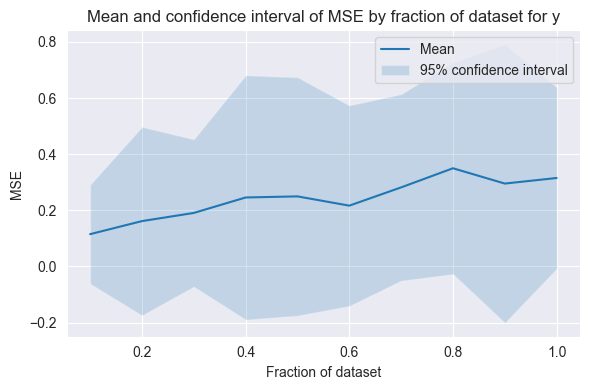

  0%|          | 1/200 [00:01<05:17,  1.59s/it]

params: [1.20450146 0.74721585 1.5682751  0.83018495]
Minimum and Maximum of sim_data: 0.2519724030559128, 4.865113992592685
MSE: 0.025050743454031098


  1%|          | 2/200 [00:03<05:35,  1.70s/it]

params: [1.40137652 0.71165934 1.42663071 1.45472905]
Minimum and Maximum of sim_data: 0.14280748690825457, 6.23836095039208
MSE: 0.11114330317502019


  2%|▏         | 3/200 [00:05<05:41,  1.74s/it]

params: [1.05373581 0.62587092 1.62977369 0.97317839]
Minimum and Maximum of sim_data: 0.3512200052748288, 3.975007818799791
MSE: 0.005622545273776581


  2%|▏         | 4/200 [00:06<05:46,  1.77s/it]

params: [1.02018386 0.54761307 1.58411096 0.90336683]
Minimum and Maximum of sim_data: 0.43699884296632197, 3.94873829654361
MSE: 0.15791033877577093


  2%|▎         | 5/200 [00:08<05:22,  1.65s/it]

params: [1.56246773 0.90796394 1.44729167 1.22373726]
Minimum and Maximum of sim_data: 0.12593376536698697, 6.23836095039208
MSE: 0.09412140596810599


  3%|▎         | 6/200 [00:10<05:29,  1.70s/it]

params: [1.19956365 0.76595168 1.48554183 0.93056456]
Minimum and Maximum of sim_data: 0.3455570056710674, 3.977897041226183
MSE: 0.049812414094641086


  4%|▎         | 7/200 [00:12<05:37,  1.75s/it]

params: [1.17103112 0.86445226 1.82022818 1.17540083]
Minimum and Maximum of sim_data: 0.09651863497347628, 5.599384080149579
MSE: 0.14732503733833124


  4%|▍         | 8/200 [00:13<05:12,  1.63s/it]

params: [1.67053022 0.79179604 1.11826792 0.92473316]
Minimum and Maximum of sim_data: 0.15587283466440446, 5.228009863738027
MSE: 0.09819711231664051


  4%|▍         | 9/200 [00:14<05:07,  1.61s/it]

params: [1.77728547 0.94029818 1.02894996 0.70669994]
Minimum and Maximum of sim_data: 0.2877611853037279, 5.0954259317103165
MSE: 0.22094641065858317


  5%|▌         | 10/200 [00:16<04:51,  1.53s/it]

params: [0.93345791 0.52406233 1.64702793 0.9077926 ]
Minimum and Maximum of sim_data: 0.47024261270756784, 3.7381983468853655
MSE: 0.037578098930938886


  6%|▌         | 11/200 [00:17<04:51,  1.54s/it]

params: [1.08571337 0.64327317 1.64304414 0.95689362]
Minimum and Maximum of sim_data: 0.236231084778616, 5.571196469396113
MSE: 0.26243509354459693


  6%|▌         | 12/200 [00:19<04:47,  1.53s/it]

params: [1.5364828  0.81290551 0.97156856 0.44682017]
Minimum and Maximum of sim_data: 0.5120657081796083, 4.564769094157203
MSE: 0.5271759567467516


  6%|▋         | 13/200 [00:21<05:10,  1.66s/it]

params: [1.14737539 0.69329207 1.95552735 1.72456334]
Minimum and Maximum of sim_data: 0.10174820289641423, 6.114004609747
MSE: 0.3494784703205608


  7%|▋         | 14/200 [00:23<05:16,  1.70s/it]

params: [1.16208741 0.57200584 1.45089809 0.81996114]
Minimum and Maximum of sim_data: 0.4571346460454454, 4.78163509155479
MSE: 0.04198664654073005


  8%|▊         | 15/200 [00:24<05:20,  1.73s/it]

params: [1.27063546 0.63149665 1.39023282 0.66356682]
Minimum and Maximum of sim_data: 0.34780871607437286, 6.114004609747
MSE: 0.07165100484910636


  8%|▊         | 16/200 [00:26<05:12,  1.70s/it]

params: [0.82831291 0.39372846 1.95501547 1.02009745]
Minimum and Maximum of sim_data: 0.5704556312151441, 4.78163509155479
MSE: 0.042951922056420754


  8%|▊         | 17/200 [00:28<05:00,  1.64s/it]

params: [1.85639328 0.8923057  0.82481741 0.48092803]
Minimum and Maximum of sim_data: 0.49651583141997385, 4.13258615143248
MSE: 0.5415228319169276


  9%|▉         | 18/200 [00:29<05:01,  1.65s/it]

params: [1.12416404 0.80668992 1.77473238 0.92284887]
Minimum and Maximum of sim_data: 0.1415342636117815, 5.1833847621956854
MSE: 0.21861013234066418


 10%|▉         | 19/200 [00:31<04:40,  1.55s/it]

params: [0.93446443 0.48456801 1.85358605 1.01217584]
Minimum and Maximum of sim_data: 0.30248043717477446, 3.152441269014908
MSE: 0.004441914898285801


 10%|█         | 20/200 [00:32<04:36,  1.54s/it]

params: [0.96069227 0.53707959 1.78382266 0.97082671]
Minimum and Maximum of sim_data: 0.34319955770736565, 4.559773495430797
MSE: 0.08436636542501255


 10%|█         | 21/200 [00:34<04:53,  1.64s/it]

params: [1.83343324 0.89296235 1.04519472 0.755611  ]
Minimum and Maximum of sim_data: 0.16347255010357528, 5.433153687077123
MSE: 0.211411004867269


 11%|█         | 22/200 [00:36<04:56,  1.67s/it]

params: [1.53242511 0.92291586 1.26252695 0.75139599]
Minimum and Maximum of sim_data: 0.25619860011992057, 5.154185399153781
MSE: 0.24794346325419045


 12%|█▏        | 23/200 [00:38<05:01,  1.71s/it]

params: [1.81650435 0.77400496 1.01109155 0.61222336]
Minimum and Maximum of sim_data: 0.21304476552086293, 6.19922528019131
MSE: 0.18197663549710297


 12%|█▏        | 24/200 [00:39<05:06,  1.74s/it]

params: [1.71519271 1.16915394 1.46588254 1.4619716 ]
Minimum and Maximum of sim_data: 0.043880869892759654, 6.345009073476603
MSE: 0.37437538785975494


 12%|█▎        | 25/200 [00:41<05:03,  1.73s/it]

params: [1.61886915 0.95220376 1.32178753 1.13263919]
Minimum and Maximum of sim_data: 0.12761362176507782, 5.52052404752254
MSE: 0.20316951212684028


 13%|█▎        | 26/200 [00:43<04:59,  1.72s/it]

params: [0.97047725 0.46716359 1.75045466 0.78886437]
Minimum and Maximum of sim_data: 0.3826849772470367, 6.145820381609693
MSE: 0.018457843923633185


 14%|█▎        | 27/200 [00:44<04:49,  1.67s/it]

params: [0.90091825 0.42807364 1.89034732 1.05112608]
Minimum and Maximum of sim_data: 0.3811578262097175, 6.206324899379912
MSE: 0.029728908536757255


 14%|█▍        | 28/200 [00:46<04:46,  1.67s/it]

params: [1.06135586 0.66880069 1.74275063 0.98600105]
Minimum and Maximum of sim_data: 0.22891234933927387, 4.784340210638217
MSE: 0.1814632635581797


 14%|█▍        | 29/200 [00:48<04:50,  1.70s/it]

params: [1.0250144  0.49328086 1.66963203 1.02328397]
Minimum and Maximum of sim_data: 0.41268332420943565, 6.070171321494975
MSE: 0.03034819923069639


 15%|█▌        | 30/200 [00:49<04:46,  1.69s/it]

params: [1.77300097 1.03599554 1.33252805 1.16348695]
Minimum and Maximum of sim_data: 0.07289764480581472, 6.23836095039208
MSE: 0.1776839677939952


 16%|█▌        | 31/200 [00:51<04:41,  1.66s/it]

params: [0.90313203 0.42714139 1.86673846 1.11598819]
Minimum and Maximum of sim_data: 0.38194929417421003, 6.181952593545626
MSE: 0.021519577910588276


 16%|█▌        | 32/200 [00:53<04:50,  1.73s/it]

params: [1.30864885 0.625146   1.38798108 0.93825239]
Minimum and Maximum of sim_data: 0.3131738435444786, 4.782990818169098
MSE: 0.03177423963183739


 16%|█▋        | 33/200 [00:54<04:42,  1.69s/it]

params: [0.99476724 0.59630942 1.74357624 0.9578314 ]
Minimum and Maximum of sim_data: 0.3107609481987316, 4.60415525212784
MSE: 0.06612775981600748


 17%|█▋        | 34/200 [00:56<04:34,  1.66s/it]

params: [1.26354643 0.57391237 1.4008358  0.9874395 ]
Minimum and Maximum of sim_data: 0.21354587188954874, 7.241741829996852
MSE: 0.19455478183740132


 18%|█▊        | 35/200 [00:58<04:39,  1.70s/it]

params: [1.0732393  0.56888616 1.69644339 0.98905056]
Minimum and Maximum of sim_data: 0.26178613969699205, 6.114004609747
MSE: 0.01908233928267422


 18%|█▊        | 36/200 [01:00<04:44,  1.73s/it]

params: [0.9485697  0.49105973 1.63717233 0.73305014]
Minimum and Maximum of sim_data: 0.47011250157892776, 5.035533631174221
MSE: 0.20993692342215894


 18%|█▊        | 37/200 [01:01<04:31,  1.66s/it]

params: [1.0324339  0.47160355 1.45081537 0.80180508]
Minimum and Maximum of sim_data: 0.6171767377012457, 5.1849717830352535
MSE: 0.22224263625855895


 19%|█▉        | 38/200 [01:03<04:31,  1.68s/it]

params: [1.0671347  0.59887224 1.62306359 0.92454326]
Minimum and Maximum of sim_data: 0.35300447104405075, 4.371243777163826
MSE: 0.05945360603366486


 20%|█▉        | 39/200 [01:05<04:34,  1.71s/it]

params: [1.1136344  0.49745442 1.50256298 0.90754074]
Minimum and Maximum of sim_data: 0.45246678079353414, 6.23836095039208
MSE: 0.16364957138996308


 20%|██        | 40/200 [01:06<04:34,  1.72s/it]

params: [1.57926984 0.78794909 1.21691054 0.81786161]
Minimum and Maximum of sim_data: 0.2291405196537841, 5.52052404752254
MSE: 0.14423637264896746


 20%|██        | 41/200 [01:08<04:40,  1.77s/it]

params: [1.76194548 1.04295843 1.37036028 1.40051126]
Minimum and Maximum of sim_data: 0.052160277833807916, 6.59999760453332
MSE: 0.510866060704376


 21%|██        | 42/200 [01:10<04:38,  1.76s/it]

params: [1.33080022 0.54318094 1.26134596 0.77687744]
Minimum and Maximum of sim_data: 0.39930143451511774, 6.255288661917225
MSE: 0.3302267055031437


 22%|██▏       | 43/200 [01:12<04:38,  1.77s/it]

params: [1.34316489 0.64600739 1.38494963 0.97593455]
Minimum and Maximum of sim_data: 0.2639793838666527, 6.240313461670839
MSE: 0.04708901210445955


 22%|██▏       | 44/200 [01:14<04:39,  1.79s/it]

params: [0.94921213 0.47904973 1.8790421  1.1848151 ]
Minimum and Maximum of sim_data: 0.2999031443715477, 6.375350539565235
MSE: 0.02245504529103762


 22%|██▎       | 45/200 [01:15<04:30,  1.74s/it]

params: [1.19015174 0.69006567 1.46466334 0.71837904]
Minimum and Maximum of sim_data: 0.36044501255360534, 5.203636702141057
MSE: 0.3616855867852201


 23%|██▎       | 46/200 [01:17<04:29,  1.75s/it]

params: [1.0193475  0.53907279 1.75948447 0.97561278]
Minimum and Maximum of sim_data: 0.26515584408326215, 6.16544323519047
MSE: 0.027804073703849835


 24%|██▎       | 47/200 [01:19<04:35,  1.80s/it]

params: [0.86205703 0.49391701 1.92739982 0.97334939]
Minimum and Maximum of sim_data: 0.28834731536093094, 5.228390436960084
MSE: 0.17024871854661466


 24%|██▍       | 48/200 [01:21<04:33,  1.80s/it]

params: [0.79867254 0.31933843 1.93608734 0.96765047]
Minimum and Maximum of sim_data: 0.7480798532136027, 5.921893087631827
MSE: 0.3236668139160329


 24%|██▍       | 49/200 [01:22<04:17,  1.71s/it]

params: [0.7910704  0.37194725 1.97415045 1.16189398]
Minimum and Maximum of sim_data: 0.4371023630540732, 5.988571477011562
MSE: 0.15587563921127723


 25%|██▌       | 50/200 [01:24<04:17,  1.72s/it]

params: [1.13467823 0.59733872 1.6426042  1.01782049]
Minimum and Maximum of sim_data: 0.2681321818293007, 6.23836095039208
MSE: 0.031679966870021545


 26%|██▌       | 51/200 [01:26<04:24,  1.78s/it]

params: [1.31551435 0.83766498 1.66700832 1.16128333]
Minimum and Maximum of sim_data: 0.11787328445929467, 6.15819446767188
MSE: 0.20602407952390098


 26%|██▌       | 52/200 [01:28<04:27,  1.80s/it]

params: [1.27458577 0.74252639 1.49349436 0.98809645]
Minimum and Maximum of sim_data: 0.23506923575483163, 5.587809550965643
MSE: 0.14599367907616134


 26%|██▋       | 53/200 [01:30<04:27,  1.82s/it]

params: [1.62812706 1.07884011 1.43945376 1.28114046]
Minimum and Maximum of sim_data: 0.06871360252878997, 6.007624791138363
MSE: 0.2668968202468213


 27%|██▋       | 54/200 [01:32<04:27,  1.83s/it]

params: [1.37811752 0.76249643 1.35400753 0.88493682]
Minimum and Maximum of sim_data: 0.2511283397962896, 5.59471327775805
MSE: 0.132199735533439


 28%|██▊       | 55/200 [01:33<04:21,  1.80s/it]

params: [1.03965717 0.66218568 1.85463232 1.06199484]
Minimum and Maximum of sim_data: 0.2179224124949913, 5.184101558485619
MSE: 0.7419554584519498


 28%|██▊       | 56/200 [01:35<04:20,  1.81s/it]

params: [0.83382926 0.42104136 1.94713188 1.01898647]
Minimum and Maximum of sim_data: 0.3877886412082036, 5.679788867610079
MSE: 0.06875672306402834


 28%|██▊       | 57/200 [01:37<04:16,  1.80s/it]

params: [1.481743   0.69563436 1.26757066 0.99449732]
Minimum and Maximum of sim_data: 0.196722971759289, 6.0607211659021285
MSE: 0.114640608327453


 29%|██▉       | 58/200 [01:39<04:23,  1.86s/it]

params: [1.17773992 0.62643123 1.70344407 1.33603664]
Minimum and Maximum of sim_data: 0.19954356248128438, 6.716121078862922
MSE: 0.11767081232454993


 30%|██▉       | 59/200 [01:41<04:22,  1.86s/it]

params: [1.2221363  0.98552246 1.81211685 1.18619617]
Minimum and Maximum of sim_data: 0.1084737514715835, 4.873292743106891
MSE: 1.114323926908887


 30%|███       | 60/200 [01:43<04:18,  1.84s/it]

params: [1.3045616  0.60502469 1.36870231 0.80121374]
Minimum and Maximum of sim_data: 0.3472628544190049, 6.260948818548163
MSE: 0.06075102394466186


 30%|███       | 61/200 [01:44<04:20,  1.88s/it]

params: [1.46204966 1.26403291 1.91342294 1.71845515]
Minimum and Maximum of sim_data: 0.030539674614309124, 6.171029302296339
MSE: 0.8526150690574479


 31%|███       | 62/200 [01:46<04:14,  1.84s/it]

params: [1.29023532 0.86552676 1.6798506  1.20830645]
Minimum and Maximum of sim_data: 0.13968027849998274, 5.636788561177184
MSE: 0.6090597831530029


 32%|███▏      | 63/200 [01:48<04:11,  1.83s/it]

params: [0.99582701 0.38945078 1.71731013 1.23875614]
Minimum and Maximum of sim_data: 0.468958259927397, 6.878491411200702
MSE: 0.49625288661300815


 32%|███▏      | 64/200 [01:50<04:10,  1.84s/it]

params: [1.78487328 1.0232783  1.29524858 1.06971321]
Minimum and Maximum of sim_data: 0.0776047996468292, 6.23836095039208
MSE: 0.28751895502684954


 32%|███▎      | 65/200 [01:52<04:06,  1.82s/it]

params: [1.04158192 0.6623548  1.66894652 0.81854034]
Minimum and Maximum of sim_data: 0.22898994011554805, 5.295436931798997
MSE: 0.3227047690284063


 33%|███▎      | 66/200 [01:53<03:59,  1.78s/it]

params: [0.9682933  0.55453712 1.89938378 1.17115429]
Minimum and Maximum of sim_data: 0.21600092104040483, 5.828022515128392
MSE: 0.09300419040733954


 34%|███▎      | 67/200 [01:55<04:00,  1.81s/it]

params: [1.1955663  0.86508129 1.94331143 1.31721746]
Minimum and Maximum of sim_data: 0.07457572350276069, 6.23836095039208
MSE: 0.4747664209824577


 34%|███▍      | 68/200 [01:57<04:10,  1.90s/it]

params: [1.38011003 0.81664804 1.71836796 1.72115344]
Minimum and Maximum of sim_data: 0.08478615450887383, 7.4058104941839105
MSE: 0.32471090427060334


 34%|███▍      | 69/200 [01:59<04:11,  1.92s/it]

params: [1.28309133 0.64574794 1.14652123 0.73136771]
Minimum and Maximum of sim_data: 0.482597740711001, 4.388392376948822
MSE: 0.48770237133952354


 35%|███▌      | 70/200 [02:02<04:41,  2.17s/it]

params: [1.37650202 0.66314384 1.41072146 1.17132935]
Minimum and Maximum of sim_data: 0.17788506245207247, 6.8040726683709485
MSE: 0.1594242633976656


 36%|███▌      | 71/200 [02:05<04:57,  2.30s/it]

params: [0.98249938 0.57303483 1.83736356 1.08913077]
Minimum and Maximum of sim_data: 0.2260012432661074, 5.755608612264128
MSE: 0.11897636285392858


 36%|███▌      | 72/200 [02:07<04:39,  2.18s/it]

params: [1.14662693 0.49994807 1.33900571 0.6438317 ]
Minimum and Maximum of sim_data: 0.7496137409467875, 5.184627148443072
MSE: 0.32276508697463324


 36%|███▋      | 73/200 [02:09<04:27,  2.11s/it]

params: [1.51495253 0.97207547 1.30558087 1.07381938]
Minimum and Maximum of sim_data: 0.18745117816510398, 4.631132576947502
MSE: 0.662976310745588


 37%|███▋      | 74/200 [02:11<04:22,  2.09s/it]

params: [1.25479409 0.67344595 1.33996008 0.68364214]
Minimum and Maximum of sim_data: 0.42478001475656196, 5.250854205803669
MSE: 0.1915507416087992


 38%|███▊      | 75/200 [02:13<04:20,  2.08s/it]

params: [1.47515097 0.77066982 1.17228133 0.64545574]
Minimum and Maximum of sim_data: 0.3306965548058283, 5.414027570722499
MSE: 0.1967618483682559


 38%|███▊      | 76/200 [02:15<04:20,  2.10s/it]

params: [1.02046664 0.7254515  1.93142167 1.12353198]
Minimum and Maximum of sim_data: 0.11986477351471601, 5.5044861942527925
MSE: 0.4775375342152118


 38%|███▊      | 77/200 [02:17<04:20,  2.12s/it]

params: [0.87826698 0.4257879  1.75599246 0.83339815]
Minimum and Maximum of sim_data: 0.5213445313171655, 5.269262206764669
MSE: 0.2521192995852595


 39%|███▉      | 78/200 [02:19<04:18,  2.12s/it]

params: [1.60873982 0.67167899 1.195052   1.10216544]
Minimum and Maximum of sim_data: 0.13953120717884557, 7.095548176470698
MSE: 0.4426824590291951


 40%|███▉      | 79/200 [02:21<04:12,  2.08s/it]

params: [1.74653622 0.76882826 1.08683987 0.74821386]
Minimum and Maximum of sim_data: 0.18652591360667684, 6.23836095039208
MSE: 0.15948807349558794


 40%|████      | 80/200 [02:23<04:02,  2.02s/it]

params: [1.3565607  0.54922629 1.1445303  0.60218908]
Minimum and Maximum of sim_data: 0.6056752607196875, 5.3571922755520385
MSE: 0.5131523623174389


 40%|████      | 81/200 [02:25<03:58,  2.00s/it]

params: [1.44915674 0.74578341 1.36246504 1.11274496]
Minimum and Maximum of sim_data: 0.16002523062921184, 6.387586660755944
MSE: 0.05347673744362988


 41%|████      | 82/200 [02:27<03:57,  2.01s/it]

params: [1.03789827 0.52378814 1.79945334 1.29985115]
Minimum and Maximum of sim_data: 0.25747407031840464, 6.725256191780223
MSE: 0.0732858431685064


 42%|████▏     | 83/200 [02:29<04:15,  2.18s/it]

params: [1.74458859 0.8650527  1.15404798 1.021549  ]
Minimum and Maximum of sim_data: 0.10533800015905558, 6.252878233615597
MSE: 0.06923285848381414


 42%|████▏     | 84/200 [02:32<04:13,  2.18s/it]

params: [1.75062585 1.07346232 1.33055051 1.23769996]
Minimum and Maximum of sim_data: 0.062037584410310195, 6.146054938977738
MSE: 0.3518811569242215


 42%|████▎     | 85/200 [02:34<03:59,  2.08s/it]

params: [1.13156155 0.59915471 1.55166423 0.80472671]
Minimum and Maximum of sim_data: 0.3780829499462872, 5.4011131291418595
MSE: 0.11205446104785878


 43%|████▎     | 86/200 [02:35<03:50,  2.02s/it]

params: [1.06404485 0.66938841 1.66116084 0.95685412]
Minimum and Maximum of sim_data: 0.3062195449343157, 4.581765150729384
MSE: 0.3489411538081505


 44%|████▎     | 87/200 [02:37<03:48,  2.02s/it]

params: [1.2265534  0.57172356 1.41001754 0.7388459 ]
Minimum and Maximum of sim_data: 0.42839674158777896, 6.130967331736515
MSE: 0.05503366401617031


 44%|████▍     | 88/200 [02:39<03:47,  2.03s/it]

params: [1.2514716  0.72194208 1.59016523 1.19971276]
Minimum and Maximum of sim_data: 0.1881221072968674, 6.266879991147147
MSE: 0.08464513831667231


 44%|████▍     | 89/200 [02:42<03:50,  2.08s/it]

params: [1.46162782 0.63581523 1.35530288 1.17891741]
Minimum and Maximum of sim_data: 0.1730179490111543, 7.116892622788584
MSE: 0.5275872524983506


 45%|████▌     | 90/200 [02:44<03:49,  2.09s/it]

params: [1.85069086 1.37664861 1.24349429 0.82276665]
Minimum and Maximum of sim_data: 0.06245569507920016, 6.711663631141909
MSE: 0.5321121373792934


 46%|████▌     | 91/200 [02:46<03:42,  2.04s/it]

params: [1.13817911 0.55315404 1.74013961 1.46507622]
Minimum and Maximum of sim_data: 0.20128334841678358, 7.702719521061681
MSE: 0.2669263563696921


 46%|████▌     | 92/200 [02:48<03:38,  2.02s/it]

params: [1.23352814 0.56743368 1.49762535 1.15767527]
Minimum and Maximum of sim_data: 0.2600897752700832, 6.737816171066081
MSE: 0.0983530508672065


 46%|████▋     | 93/200 [02:50<03:37,  2.03s/it]

params: [1.80681819 0.96997751 1.0753662  0.74370546]
Minimum and Maximum of sim_data: 0.14422749622667455, 5.399714298663174
MSE: 0.13799557885852867


 47%|████▋     | 94/200 [02:52<03:35,  2.04s/it]

params: [1.04362396 0.5611716  1.59493414 0.79918431]
Minimum and Maximum of sim_data: 0.38501523823639366, 5.2340165044447815
MSE: 0.15566952388761593


 48%|████▊     | 95/200 [02:54<03:36,  2.06s/it]

params: [1.12349008 0.52904426 1.56565054 1.06276605]
Minimum and Maximum of sim_data: 0.34789342401482876, 6.514439943015717
MSE: 0.17420746374337834


 48%|████▊     | 96/200 [02:56<03:32,  2.05s/it]

params: [1.34888081 0.72104971 1.36007594 0.87956853]
Minimum and Maximum of sim_data: 0.2772911429648307, 5.502543147186634
MSE: 0.09397903850296102


 48%|████▊     | 97/200 [02:58<03:38,  2.12s/it]

params: [0.92738343 0.44340412 1.94574763 1.28782725]
Minimum and Maximum of sim_data: 0.29076103411874055, 6.91634410745046
MSE: 0.11072555806326508


 49%|████▉     | 98/200 [03:00<03:32,  2.09s/it]

params: [1.33660193 0.92126196 1.78547732 1.5565583 ]
Minimum and Maximum of sim_data: 0.08654037191158667, 6.254431597395209
MSE: 0.5401252227974246


 50%|████▉     | 99/200 [03:02<03:28,  2.06s/it]

params: [1.30759717 0.69620498 1.49617629 1.03220945]
Minimum and Maximum of sim_data: 0.2201845813553969, 6.379790014382232
MSE: 0.03786213548896745


 50%|█████     | 100/200 [03:04<03:19,  2.00s/it]

params: [1.02364571 0.5318074  1.66831178 0.90427295]
Minimum and Maximum of sim_data: 0.34993469546037564, 5.730969370031788
MSE: 0.04369320060505784


 50%|█████     | 101/200 [03:06<03:22,  2.04s/it]

params: [1.04083002 0.45936026 1.75724131 1.28930337]
Minimum and Maximum of sim_data: 0.3267400256920202, 7.401497165542681
MSE: 0.2650797618051067


 51%|█████     | 102/200 [03:08<03:20,  2.04s/it]

params: [0.99538695 0.46089459 1.76696289 1.16662781]
Minimum and Maximum of sim_data: 0.3560544546533542, 6.688994832736052
MSE: 0.07869934091329048


 52%|█████▏    | 103/200 [03:11<03:26,  2.13s/it]

params: [1.30812168 0.74320586 1.56196536 1.07858043]
Minimum and Maximum of sim_data: 0.18751389958464643, 6.400861246108074
MSE: 0.09242800575348098


 52%|█████▏    | 104/200 [03:13<03:26,  2.15s/it]

params: [1.35631059 0.63891055 1.43492289 1.24214165]
Minimum and Maximum of sim_data: 0.17718918453101348, 6.961290384121099
MSE: 0.1304614391033627


 52%|█████▎    | 105/200 [03:15<03:23,  2.14s/it]

params: [1.68541569 1.18054396 1.61466029 1.84177556]
Minimum and Maximum of sim_data: 0.030080357509855726, 6.984118236712059
MSE: 0.5348900626042458


 53%|█████▎    | 106/200 [03:17<03:14,  2.07s/it]

params: [1.29539153 0.68214707 1.32053261 0.72968612]
Minimum and Maximum of sim_data: 0.3935221984987387, 5.279646035298302
MSE: 0.14075994177557133


 54%|█████▎    | 107/200 [03:19<03:10,  2.05s/it]

params: [0.97479119 0.53063455 1.96189689 1.66956992]
Minimum and Maximum of sim_data: 0.22415464412847372, 6.314066548333253
MSE: 0.13536863846588817


 54%|█████▍    | 108/200 [03:21<03:06,  2.03s/it]

params: [1.44791653 0.65674224 1.24747821 0.93611575]
Minimum and Maximum of sim_data: 0.23488224497780102, 6.210955655309877
MSE: 0.09341438171807442


 55%|█████▍    | 109/200 [03:23<03:06,  2.05s/it]

params: [0.9205732  0.42739978 1.71791722 1.073309  ]
Minimum and Maximum of sim_data: 0.4325713786247445, 6.145392304935094
MSE: 0.5320335815414403


 55%|█████▌    | 110/200 [03:25<03:03,  2.04s/it]

params: [1.53949339 0.69121535 1.18821615 0.92375888]
Minimum and Maximum of sim_data: 0.20493087191470877, 6.211928670103996
MSE: 0.08741798974842913


 56%|█████▌    | 111/200 [03:27<03:03,  2.06s/it]

params: [1.16227345 0.68786468 1.71554811 1.2534916 ]
Minimum and Maximum of sim_data: 0.16731311222757847, 6.295897110996046
MSE: 0.131390297319391


 56%|█████▌    | 112/200 [03:29<03:02,  2.07s/it]

params: [1.95119606 0.85890561 0.87129643 0.47360817]
Minimum and Maximum of sim_data: 0.3072992628138021, 5.669270564819356
MSE: 0.4233097627311926


 56%|█████▋    | 113/200 [03:31<03:04,  2.12s/it]

params: [1.13707831 0.90332473 1.86217787 1.10830207]
Minimum and Maximum of sim_data: 0.0802721606548016, 5.488973270262771
MSE: 0.7650013916030722


 57%|█████▋    | 114/200 [03:33<02:59,  2.08s/it]

params: [1.74477708 0.84390723 1.18478424 0.86474661]
Minimum and Maximum of sim_data: 0.1352766915198816, 6.370890307614484
MSE: 0.293984166955707


 57%|█████▊    | 115/200 [03:35<02:56,  2.08s/it]

params: [1.34245076 0.56226687 1.25986227 0.76922834]
Minimum and Maximum of sim_data: 0.3765869575001492, 6.248716040212915
MSE: 0.2703812228035958


 58%|█████▊    | 116/200 [03:37<02:53,  2.07s/it]

params: [0.99397897 0.4490513  1.74286448 1.14683547]
Minimum and Maximum of sim_data: 0.40651003465946384, 6.544393288432506
MSE: 0.12687580942163068


 58%|█████▊    | 117/200 [03:40<02:51,  2.06s/it]

params: [1.27659584 0.86804916 1.8191236  1.3625948 ]
Minimum and Maximum of sim_data: 0.08260964447358424, 6.453352459745487
MSE: 0.5038732595758109


 59%|█████▉    | 118/200 [03:42<02:47,  2.04s/it]

params: [0.79153905 0.3822917  1.92592887 0.89576351]
Minimum and Maximum of sim_data: 0.5185770897524598, 5.3006223891154916
MSE: 0.32369873710650837


 60%|█████▉    | 119/200 [03:44<02:44,  2.03s/it]

params: [1.68991097 0.81659943 1.11262301 0.79575011]
Minimum and Maximum of sim_data: 0.19809752922364798, 5.52052404752254
MSE: 0.21141201411059965


 60%|██████    | 120/200 [03:45<02:39,  1.99s/it]

params: [1.15819825 0.78210997 1.90553433 1.51762415]
Minimum and Maximum of sim_data: 0.08315147826949089, 6.538800251420677
MSE: 0.312757631033818


 60%|██████    | 121/200 [03:48<02:40,  2.03s/it]

params: [1.56072919 0.86717411 1.22752154 0.78759172]
Minimum and Maximum of sim_data: 0.20857705193579668, 5.391054956696604
MSE: 0.2517027296238877


 61%|██████    | 122/200 [03:50<02:40,  2.06s/it]

params: [1.27618695 0.93239101 1.90705672 1.41491332]
Minimum and Maximum of sim_data: 0.05954223467099073, 6.443849512362602
MSE: 0.6414205692068843


 62%|██████▏   | 123/200 [03:52<02:39,  2.07s/it]

params: [1.42402587 1.04631883 1.53815219 1.02804915]
Minimum and Maximum of sim_data: 0.10921807160827021, 5.710795744930765
MSE: 0.5608309228482238


 62%|██████▏   | 124/200 [03:54<02:35,  2.05s/it]

params: [1.22956711 0.78692473 1.69454973 1.29826901]
Minimum and Maximum of sim_data: 0.12505264790644036, 6.232152093595751
MSE: 0.21214722151454912


 62%|██████▎   | 125/200 [03:56<02:28,  1.98s/it]

params: [0.767004   0.34553052 1.92184502 0.81643391]
Minimum and Maximum of sim_data: 0.695890385785822, 5.1103328125328105
MSE: 0.3887275134765567


 63%|██████▎   | 126/200 [03:58<02:27,  1.99s/it]

params: [1.61546131 0.89587912 1.3657365  1.12707389]
Minimum and Maximum of sim_data: 0.09843031762205695, 6.5704487643382485
MSE: 0.14146449876487635


 64%|██████▎   | 127/200 [04:00<02:25,  2.00s/it]

params: [1.42936393 0.88139898 1.49778951 1.18038901]
Minimum and Maximum of sim_data: 0.13494192338120228, 6.0077873837849625
MSE: 0.311081242052406


 64%|██████▍   | 128/200 [04:02<02:24,  2.00s/it]

params: [0.97147593 0.49932462 1.95084488 1.3546393 ]
Minimum and Maximum of sim_data: 0.22181423387120586, 6.9081594441310346
MSE: 0.1446279437570106


 64%|██████▍   | 129/200 [04:04<02:23,  2.02s/it]

params: [1.49772106 0.72673153 1.37290844 1.32547255]
Minimum and Maximum of sim_data: 0.10655769868217238, 7.2044354378383195
MSE: 0.2541060712377794


 65%|██████▌   | 130/200 [04:06<02:21,  2.02s/it]

params: [1.11751703 0.7406933  1.88547748 1.16976332]
Minimum and Maximum of sim_data: 0.10435779489350312, 6.287986064000316
MSE: 0.3031361845713435


 66%|██████▌   | 131/200 [04:08<02:19,  2.02s/it]

params: [1.42597131 0.74779467 1.40565542 1.16757101]
Minimum and Maximum of sim_data: 0.1525282986418348, 6.483336626754888
MSE: 0.061535701589613724


 66%|██████▌   | 132/200 [04:10<02:15,  2.00s/it]

params: [1.66854518 0.85911472 1.38438665 1.53179793]
Minimum and Maximum of sim_data: 0.057215968339045215, 7.296304771897803
MSE: 0.197518925696576


 66%|██████▋   | 133/200 [04:12<02:14,  2.01s/it]

params: [1.43931736 0.93621469 1.51034247 1.23187903]
Minimum and Maximum of sim_data: 0.1102575304329655, 6.062954499769447
MSE: 0.30529678905444235


 67%|██████▋   | 134/200 [04:14<02:10,  1.98s/it]

params: [1.49139665 0.65204026 1.15431505 0.7893744 ]
Minimum and Maximum of sim_data: 0.2970287082555426, 5.834034293780129
MSE: 0.19486798581675358


 68%|██████▊   | 135/200 [04:16<02:08,  1.98s/it]

params: [1.14143165 0.57025076 1.49973423 0.94494099]
Minimum and Maximum of sim_data: 0.3737235120264721, 5.874093605162876
MSE: 0.1328282149334107


 68%|██████▊   | 136/200 [04:18<02:06,  1.98s/it]

params: [1.17796209 0.7770697  1.75981482 1.2716419 ]
Minimum and Maximum of sim_data: 0.1201425548821605, 6.057166291825219
MSE: 0.302781852476729


 68%|██████▊   | 137/200 [04:20<02:06,  2.00s/it]

params: [1.48730714 0.82601096 1.42246425 1.07229897]
Minimum and Maximum of sim_data: 0.13663905938818735, 6.463979522454349
MSE: 0.10026589690151164


 69%|██████▉   | 138/200 [04:21<02:01,  1.96s/it]

params: [1.72332322 0.83577683 1.08661761 0.81249751]
Minimum and Maximum of sim_data: 0.1669655027163107, 5.726725995500764
MSE: 0.09409503747316421


 70%|██████▉   | 139/200 [04:23<01:59,  1.95s/it]

params: [1.81377811 1.12225681 1.36726179 1.15052915]
Minimum and Maximum of sim_data: 0.052821194710318056, 6.4872235336239035
MSE: 0.22060326164801278


 70%|███████   | 140/200 [04:25<01:57,  1.96s/it]

params: [1.23037836 0.67859769 1.59988486 1.19270483]
Minimum and Maximum of sim_data: 0.21616316465233915, 6.295670598619646
MSE: 0.09966163109987976


 70%|███████   | 141/200 [04:27<01:55,  1.95s/it]

params: [1.95242665 1.2375268  1.22249194 1.03326043]
Minimum and Maximum of sim_data: 0.06169608794056114, 5.52052404752254
MSE: 0.4583145456106637


 71%|███████   | 142/200 [04:29<01:52,  1.95s/it]

params: [1.504961   0.81870602 1.40799756 1.26778815]
Minimum and Maximum of sim_data: 0.1092735181765196, 6.632431330404789
MSE: 0.07257551508270368


 72%|███████▏  | 143/200 [04:31<01:50,  1.94s/it]

params: [1.65713142 0.68149086 0.94715472 0.47215263]
Minimum and Maximum of sim_data: 0.5219846521424552, 5.080282686483509
MSE: 0.5919926880655794


 72%|███████▏  | 144/200 [04:33<01:50,  1.97s/it]

params: [1.16673483 0.68480062 1.81525926 1.48605549]
Minimum and Maximum of sim_data: 0.1273265181757688, 6.936231565703501
MSE: 0.23724559373442172


 72%|███████▎  | 145/200 [04:35<01:48,  1.98s/it]

params: [1.3541714  0.89268651 1.89327427 1.99732043]
Minimum and Maximum of sim_data: 0.049646906916992, 7.6983708946285185
MSE: 0.5759948046931391


 73%|███████▎  | 146/200 [04:37<01:46,  1.97s/it]

params: [1.83015293 0.76425191 1.01800533 0.8699522 ]
Minimum and Maximum of sim_data: 0.14880937535512487, 6.29066966647711
MSE: 0.27386115560602053


 74%|███████▎  | 147/200 [04:39<01:45,  1.99s/it]

params: [1.13768454 0.6617586  1.90394164 1.64616037]
Minimum and Maximum of sim_data: 0.10440368630539221, 7.378128335403241
MSE: 0.23397316830223422


 74%|███████▍  | 148/200 [04:41<01:41,  1.95s/it]

params: [1.6570425  0.71096021 1.10972589 0.75730397]
Minimum and Maximum of sim_data: 0.22343132594074952, 6.23836095039208
MSE: 0.23390538163648414


 74%|███████▍  | 149/200 [04:43<01:38,  1.93s/it]

params: [1.24371707 0.96126349 1.75254053 1.15085033]
Minimum and Maximum of sim_data: 0.08254158520755056, 5.511647431222777
MSE: 0.5588660792465971


 75%|███████▌  | 150/200 [04:45<01:36,  1.92s/it]

params: [1.16795418 0.55155084 1.57078224 1.12605507]
Minimum and Maximum of sim_data: 0.30705431002241507, 6.621155958796009
MSE: 0.08682673390354324


 76%|███████▌  | 151/200 [04:47<01:34,  1.94s/it]

params: [1.61386719 0.91524208 1.33181499 1.15593407]
Minimum and Maximum of sim_data: 0.10000608822836848, 6.136885178779668
MSE: 0.17869354570786913


 76%|███████▌  | 152/200 [04:49<01:33,  1.94s/it]

params: [1.62787199 0.7624538  1.20207795 0.86251097]
Minimum and Maximum of sim_data: 0.17147568352947856, 6.399610642537072
MSE: 0.12272969108197747


 76%|███████▋  | 153/200 [04:51<01:33,  1.99s/it]

params: [1.32215065 0.70397064 1.42263759 1.01421948]
Minimum and Maximum of sim_data: 0.23353752805361833, 5.999141771831372
MSE: 0.0419635295531307


 77%|███████▋  | 154/200 [04:53<01:31,  1.98s/it]

params: [1.07607496 0.4958876  1.5032433  0.84006894]
Minimum and Maximum of sim_data: 0.5341918309945449, 5.653456699663242
MSE: 0.15429966978878024


 78%|███████▊  | 155/200 [04:55<01:29,  1.98s/it]

params: [1.16251817 0.57917537 1.43981099 0.80250609]
Minimum and Maximum of sim_data: 0.4499850080236422, 5.457447800964566
MSE: 0.10405866399860952


 78%|███████▊  | 156/200 [04:57<01:26,  1.97s/it]

params: [1.68869583 0.72328464 1.02340237 0.69798705]
Minimum and Maximum of sim_data: 0.2658169297259271, 5.649601763344432
MSE: 0.28879459559284987


 78%|███████▊  | 157/200 [04:59<01:23,  1.94s/it]

params: [1.79944342 0.74458207 1.03666122 0.72643681]
Minimum and Maximum of sim_data: 0.18976447679573227, 6.354040790629834
MSE: 0.3072608800897352


 79%|███████▉  | 158/200 [05:00<01:19,  1.90s/it]

params: [1.04602074 0.51744841 1.58136704 0.87203784]
Minimum and Maximum of sim_data: 0.43898198254078885, 5.559905681544709
MSE: 0.08075442384232796


 80%|███████▉  | 159/200 [05:02<01:19,  1.94s/it]

params: [0.90782385 0.43441755 1.83408168 1.02120904]
Minimum and Maximum of sim_data: 0.42595731321438063, 5.916667379582337
MSE: 0.05446241357938082


 80%|████████  | 160/200 [05:04<01:17,  1.94s/it]

params: [1.9599852  0.78096026 0.95097827 0.68765448]
Minimum and Maximum of sim_data: 0.17624100402890044, 6.23836095039208
MSE: 0.4477185521559884


 80%|████████  | 161/200 [05:06<01:16,  1.97s/it]

params: [1.83538162 1.05643803 1.3348036  1.49579769]
Minimum and Maximum of sim_data: 0.038180722982189344, 6.887182450204504
MSE: 0.19113606852516674


 81%|████████  | 162/200 [05:08<01:15,  1.99s/it]

params: [1.38173549 0.9035526  1.49716482 1.07805321]
Minimum and Maximum of sim_data: 0.1494909528523661, 5.719323331886006
MSE: 0.30042745417636246


 82%|████████▏ | 163/200 [05:10<01:13,  1.98s/it]

params: [1.81536836 1.02668023 1.28050695 1.13061874]
Minimum and Maximum of sim_data: 0.07139184340433388, 6.242477400470088
MSE: 0.2142298301847899


 82%|████████▏ | 164/200 [05:12<01:10,  1.95s/it]

params: [1.66156529 0.76438416 1.03221839 0.62894935]
Minimum and Maximum of sim_data: 0.29475474015901065, 5.320343708314572
MSE: 0.24078233007616462


 82%|████████▎ | 165/200 [05:14<01:08,  1.96s/it]

params: [1.64149387 0.87743079 1.15963958 0.80912012]
Minimum and Maximum of sim_data: 0.17184263371184502, 5.540627210344402
MSE: 0.12109096063630694


 83%|████████▎ | 166/200 [05:16<01:07,  1.98s/it]

params: [1.38478273 0.9510727  1.61204858 1.26131318]
Minimum and Maximum of sim_data: 0.10652511742925817, 5.96154647772843
MSE: 0.42229130374797563


 84%|████████▎ | 167/200 [05:18<01:06,  2.00s/it]

params: [1.57248238 0.76409712 1.2847243  1.17179977]
Minimum and Maximum of sim_data: 0.11780849024016096, 6.740090080747153
MSE: 0.08695472946241291


 84%|████████▍ | 168/200 [05:20<01:03,  1.97s/it]

params: [1.39042935 0.62788215 1.28472041 0.97000626]
Minimum and Maximum of sim_data: 0.24174563526957715, 6.347121264843566
MSE: 0.1772246601121719


 84%|████████▍ | 169/200 [05:22<01:01,  1.98s/it]

params: [1.37281022 0.79378584 1.52953665 1.27584152]
Minimum and Maximum of sim_data: 0.1385566511126973, 6.459293156810817
MSE: 0.12867867782270215


 85%|████████▌ | 170/200 [05:24<00:59,  1.98s/it]

params: [0.96476339 0.48291257 1.72936898 0.99273729]
Minimum and Maximum of sim_data: 0.37743799957208296, 5.85365453253039
MSE: 0.06732822517840681


 86%|████████▌ | 171/200 [05:26<00:57,  1.98s/it]

params: [1.25499231 0.98822484 1.77238639 1.20041814]
Minimum and Maximum of sim_data: 0.07314812247803575, 5.568610440869714
MSE: 0.7160332728567994


 86%|████████▌ | 172/200 [05:28<00:55,  1.97s/it]

params: [1.03795307 0.47646648 1.60232659 0.89894127]
Minimum and Maximum of sim_data: 0.5198369221101713, 5.758477157854108
MSE: 0.18407456379238238


 86%|████████▋ | 173/200 [05:30<00:52,  1.95s/it]

params: [1.94640118 0.94312897 1.01227616 0.82593824]
Minimum and Maximum of sim_data: 0.11186046350840098, 5.782077829751055
MSE: 0.11683341665213447


 87%|████████▋ | 174/200 [05:32<00:51,  1.99s/it]

params: [1.88120417 0.95332566 1.11359217 1.02662587]
Minimum and Maximum of sim_data: 0.08022315008253436, 6.1850002222823965
MSE: 0.076760923283092


 88%|████████▊ | 175/200 [05:34<00:49,  1.96s/it]

params: [1.529638   0.87399973 1.41355759 1.27243664]
Minimum and Maximum of sim_data: 0.09825101048698323, 6.493050955634929
MSE: 0.1173927637487462


 88%|████████▊ | 176/200 [05:36<00:46,  1.93s/it]

params: [1.00683706 0.49752275 1.77658391 1.18086209]
Minimum and Maximum of sim_data: 0.29904121741492146, 6.540536557995986
MSE: 0.032443353351548784


 88%|████████▊ | 177/200 [05:38<00:45,  1.96s/it]

params: [1.7245931  0.99593782 1.17692774 0.85013655]
Minimum and Maximum of sim_data: 0.12439003917042527, 5.507581175520829
MSE: 0.17191245885614428


 89%|████████▉ | 178/200 [05:40<00:43,  1.99s/it]

params: [1.15713308 0.67712859 1.61463215 1.09754056]
Minimum and Maximum of sim_data: 0.2053206204771018, 5.924083581201598
MSE: 0.216453134387855


 90%|████████▉ | 179/200 [05:42<00:41,  1.96s/it]

params: [1.04239316 0.41518487 1.43175481 0.69668464]
Minimum and Maximum of sim_data: 0.8798247691902719, 5.363460182837148
MSE: 0.6041456510864536


 90%|█████████ | 180/200 [05:44<00:40,  2.01s/it]

params: [1.3584073  0.81167146 1.49971914 1.13196107]
Minimum and Maximum of sim_data: 0.16777283216813454, 6.0186120293438305
MSE: 0.14794151662230715


 90%|█████████ | 181/200 [05:46<00:38,  2.02s/it]

params: [1.41249826 0.78985204 1.28447452 0.74297753]
Minimum and Maximum of sim_data: 0.29054094335670416, 5.315987335469363
MSE: 0.1925868184187504


 91%|█████████ | 182/200 [05:48<00:35,  1.99s/it]

params: [1.15375176 0.6413081  1.71506238 1.28663854]
Minimum and Maximum of sim_data: 0.18991144943760227, 6.566776890947422
MSE: 0.10723666104639046


 92%|█████████▏| 183/200 [05:50<00:33,  1.95s/it]

params: [1.53307141 0.74421297 1.1354367  0.70027607]
Minimum and Maximum of sim_data: 0.29291715102381183, 5.409121329991775
MSE: 0.15262494100236423


 92%|█████████▏| 184/200 [05:52<00:31,  1.98s/it]

params: [1.64442083 1.23480257 1.49196723 1.2522161 ]
Minimum and Maximum of sim_data: 0.058782943570555045, 5.764738349258303
MSE: 0.6066534707832928


 92%|█████████▎| 185/200 [05:54<00:29,  1.99s/it]

params: [1.75967138 0.89724591 1.32897523 1.51349471]
Minimum and Maximum of sim_data: 0.04906482969061078, 7.448287692196656
MSE: 0.22343480268762084


 93%|█████████▎| 186/200 [05:56<00:28,  2.03s/it]

params: [1.76697448 1.04204541 1.24331874 1.06937878]
Minimum and Maximum of sim_data: 0.0784192467713706, 5.897526774792557
MSE: 0.18757218500951936


 94%|█████████▎| 187/200 [05:58<00:26,  2.05s/it]

params: [1.17589913 0.67721617 1.62898403 1.10252947]
Minimum and Maximum of sim_data: 0.2172893890674676, 5.962645154041391
MSE: 0.13587827784135148


 94%|█████████▍| 188/200 [06:00<00:24,  2.02s/it]

params: [0.95237043 0.56691921 1.97612129 1.26499828]
Minimum and Maximum of sim_data: 0.17259798961426112, 6.178492778283968
MSE: 0.11574842266521017


 94%|█████████▍| 189/200 [06:02<00:21,  1.98s/it]

params: [1.9295696  0.77848142 0.82212669 0.42240111]
Minimum and Maximum of sim_data: 0.4177313321529935, 5.398350411652334
MSE: 0.7216403982977546


 95%|█████████▌| 190/200 [06:04<00:20,  2.05s/it]

params: [1.02074469 0.44308941 1.71789944 1.14509591]
Minimum and Maximum of sim_data: 0.42150126444623387, 6.841920951033113
MSE: 0.2111764980058716


 96%|█████████▌| 191/200 [06:06<00:18,  2.06s/it]

params: [1.30245013 0.79984159 1.64574679 1.33184817]
Minimum and Maximum of sim_data: 0.13634798690206487, 6.371354625816338
MSE: 0.2594218651178933


 96%|█████████▌| 192/200 [06:08<00:16,  2.03s/it]

params: [1.35785774 0.77803638 1.37568462 0.88973401]
Minimum and Maximum of sim_data: 0.2420453829296954, 5.552306684255713
MSE: 0.13554414164254103


 96%|█████████▋| 193/200 [06:10<00:13,  1.99s/it]

params: [1.40148729 0.66961724 1.16441725 0.61539307]
Minimum and Maximum of sim_data: 0.44512433317910793, 5.176328555501031
MSE: 0.2604038240078405


 97%|█████████▋| 194/200 [06:12<00:11,  1.96s/it]

params: [1.27881368 0.56193788 1.45540636 1.15730868]
Minimum and Maximum of sim_data: 0.23986787302239793, 7.041337313243215
MSE: 0.21129975803702156


 98%|█████████▊| 195/200 [06:14<00:09,  1.95s/it]

params: [1.21342148 0.54142218 1.39616524 0.86995828]
Minimum and Maximum of sim_data: 0.43256052699376607, 5.909406002171089
MSE: 0.14949791267766918


 98%|█████████▊| 196/200 [06:16<00:07,  1.94s/it]

params: [1.42621964 0.65088918 1.24783409 0.85814911]
Minimum and Maximum of sim_data: 0.29033748923123737, 5.925199073107116
MSE: 0.15860563111288076


 98%|█████████▊| 197/200 [06:18<00:05,  1.98s/it]

params: [1.57700194 0.76010409 1.0663465  0.58435192]
Minimum and Maximum of sim_data: 0.34758309907012075, 5.329317959233728
MSE: 0.25873621819960513


 99%|█████████▉| 198/200 [06:20<00:03,  1.99s/it]

params: [0.89068356 0.57909246 1.98171892 1.00665467]
Minimum and Maximum of sim_data: 0.18990679068265853, 5.317437017479947
MSE: 0.3315929073843415


100%|█████████▉| 199/200 [06:22<00:01,  1.99s/it]

params: [1.09383592 0.49193111 1.51225981 0.93366002]
Minimum and Maximum of sim_data: 0.4721531371083157, 6.060603818592314
MSE: 0.17822969818879703


100%|██████████| 200/200 [06:24<00:00,  1.92s/it]

params: [1.05843076 0.41824845 1.40302068 0.66832683]
Minimum and Maximum of sim_data: 0.9120141157299892, 5.288057890279198
MSE: 0.6403542340886885


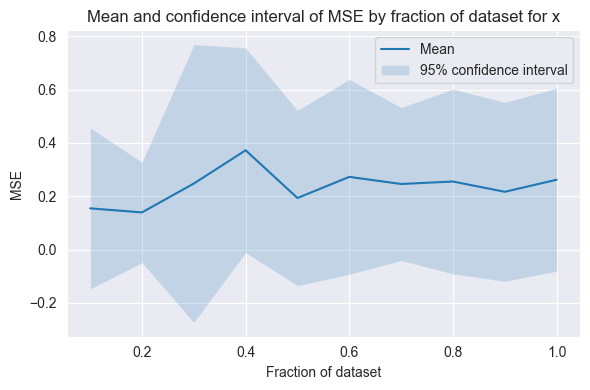

In [93]:
for data_variable in ['y', 'x']:
    try:
        experiment_df = batch_comparison_by_frac(fracs=fracs, data_variable=data_variable,
                                             n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA,
                                             data=data)
    except Exception as e:
        print(f"An error occurred: {e}")

    plt.figure(figsize=(6, 4), layout='tight')
    plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
    plt.fill_between(experiment_df['frac'],
                     experiment_df['conf_int'].apply(lambda x: x[0]),
                     experiment_df['conf_int'].apply(lambda x: x[1]),
                     alpha=0.2, label='95% confidence interval')
    plt.title(f'Mean and confidence interval of MSE by fraction of dataset for {data_variable}')
    plt.xlabel('Fraction of dataset')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

#### How many data-points from each time-series you could remove until you are not able to reverse-engineer the parameters any more?

First, try to ﬁnd the importance of each time-series on reverse-engineering process by ﬁxing one time-series and removing data-points from the other one. In this way, you will ﬁnd the critical number of data-points for each time-series.

Then, if you combine two reduced time-series, could you still infer the parameters?

Does removing every data-point have the same effect on reverse-engineering process? In other words, what are the points that you could remove safely without affecting the inferance procedure? and what are those with critical effects on the process?

#### \<Extra question\>